__Warning__
********************************

_LSFMs only evaluate SFs for a fixed target policy that selects actions uni-formly at random.  The learned model can then be used to predict the valuefunction of any arbitrary policy, including the optimal policy._

_LSFMs do not include a value prediction module_

_test different alpha for the loss_ : results : alpha_N = 1.0 / alpha_psi = 0.01

*********************************

__BUGS__
Attention : ne pas faire de _reset_LSFM_ : probleme d'allocation de nouveau tenseur je pense

# Commits and folder name

hidden layer dimension (LSFM or DQN) = latent layer dimension = dim origine state space / .....

Smaller env

In [1]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
 
print("now =", now)

# dd/mm/YY H:M:S
dt_string = now.strftime("%Y-%m-%d_%Hh-%Mm-%Ss")
print("date and time =", dt_string)

now = 2021-06-10 09:31:27.707727
date and time = 2021-06-10_09h-31m-27s


In [2]:
folder_WORK = "LSFM_V2.5_dim1.2-hidden_ratio_1"+dt_string

# Environment

In [3]:
import gym
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers, Input


import random
import numpy as np
import datetime as dt
import math

import pandas as pd
import seaborn as sns
sns.set()


import matplotlib.pyplot as plt
from gridworld import SimpleGrid

# tf.keras.backend.floatx()

# tf.keras.backend.set_floatx('float32')
# tf.keras.backend.floatx()


In [4]:
class custom_env:

    def __init__(self, env_name, param={}):
        # Initialize atributes
        self.env_name = env_name    # name of environment
        self.param = param          # dictionarry of environment parameters

        if (self.env_name == "SimpleGrid"):
            self.env = SimpleGrid(self.param["grid_size"],
                                  block_pattern=self.param["pattern"],
                                  obs_mode=self.param["obs_mode"])

            self.state_space = gym.spaces.Discrete(4)
            self.env.reset(
                agent_pos=self.param["agent_pos"], 
                goal_pos=self.param["goal_pos"],
                reward_pos=self.param["reward_pos"],
                reward_minmax = self.param["reward_minmax"],
                reward_user_defined = self.param["reward_user_defined"]
            )

            self.state_type = "Discrete"
            self.observation_space = gym.spaces.Discrete(
                self.param["grid_size"]**2)
            
            self.action_space = gym.spaces.Discrete(4)
            
        if (self.env_name.split("_")[0] == "gym"):
            gym_name = "_".join(self.env_name.split("_")[1:])
            self.env = gym.make(gym_name)
            self.action_space = self.env.action_space
            if (type(self.env.observation_space) == gym.spaces.discrete.Discrete):
                self.observation_space = self.env.observation_space
                self.state_type = "Discrete"
                                
            else:
                self.state_type = "Continue"

        observation = self.reset()
        
        if self.state_type == "Discrete":
            self._state_dim = self.observation_space.n
        else:
            self._state_dim = len(observation)

    def reset(self):
        
        
        if self.state_type == "Discrete":
            if (self.env_name == "SimpleGrid"):
                self.env.reset(
                agent_pos=self.param["agent_pos"], 
                goal_pos=self.param["goal_pos"],
                reward_pos=self.param["reward_pos"] ,
                reward_minmax = self.param["reward_minmax"],
                reward_user_defined = self.param["reward_user_defined"]
                )
                                
                n = self.observation_space.n
                return_reset = np.array(keras.utils.to_categorical(
                    self.env.observation,   
                    num_classes=n)).reshape(n)
            else : 
                
                state_res = self.env.reset()
                
                n = self.observation_space.n
                return_reset = np.array(keras.utils.to_categorical(
                    state_res, 
                    num_classes=n)).reshape(n)
                
        else : 
            return_reset = self.env.reset()
        
        return return_reset

    def step(self, action):
        
                    
        if self.state_type == "Discrete":
            
            if (self.env_name == "SimpleGrid"):
                reward = self.env.step(action)
                done = self.env.done
                info = ""
                n = self.observation_space.n
                next_state = np.array(keras.utils.to_categorical(
                    self.env.observation, 
                    num_classes=n)).reshape(n)

                return_env = np.array(next_state), reward, done, info
            
            else :
            
                next_state, reward, done, info = self.env.step(action)

                n = self.observation_space.n
                next_state = np.array(keras.utils.to_categorical(
                    next_state, 
                    num_classes=n)).reshape(n)

                return_env = np.array(next_state), reward, done, info
            
        else:
            return_env = self.env.step(action)

        
        return return_env
        
        
    def render(self):
        if (self.env_name == "SimpleGrid"):
            
            fig, ax = plt.subplots()
            ax.imshow(self.env.grid)

            # Minor ticks
            ax.set_xticks(np.arange(-.5, (self._state_dim)**0.5 - 1, 1), minor=True)
            ax.set_yticks(np.arange(-.5, (self._state_dim)**0.5 - 1, 1), minor=True)

            # Gridlines based on minor ticks
            ax.grid(which='both', color='w', linestyle='-', linewidth=1.5)
        if (self.env_name.split("_")[0] == "gym"):
            self.env.render()

            
    def render_state(self, state) : 
        if (self.env_name == "SimpleGrid"):
            
            fig, ax = plt.subplots()
            ax.imshow(self.env.grid_state(state))

            # Minor ticks
            ax.set_xticks(np.arange(-.5, (self._state_dim)**0.5 - 1, 1), minor=True)
            ax.set_yticks(np.arange(-.5, (self._state_dim)**0.5 - 1, 1), minor=True)

            # Gridlines based on minor ticks
            ax.grid(which='both', color='w', linestyle='-', linewidth=1.5)
        
        
    def close(self):
        if (self.env_name.split("_")[0] == "gym"):
            self.env.close()


# Agents

## LSFM

In [5]:

class Agent:
    
        
    def __init__(self, enviroment, param={}):
        self.param = param
        self._action_size = enviroment.action_space.n
        self._state_dim = enviroment._state_dim
        self.dim_latent = self.param["latent_space"]
        self.hidden_dim = int(self.param["latent_space"] * self.param["hidden_dim_ratio"])
        self.batch_size = self.param["batch_size"]
        
#         LSFM model for construction of a reward-predictive space representation  
#         LSFM must be train on policy independant of state
        inputs = Input(shape=(self._state_dim,), name="input")
        x = layers.Dense(self.hidden_dim, activation='relu', name="hidden_latent")(inputs)
        layer_latent = layers.Dense(self.dim_latent, activation='relu', name="latent")(x)
        layers_ouputs = {}

        x = layers.Dense(self.dim_latent * self._action_size,use_bias=False, name = "Fa")(layer_latent)
        layers_ouputs["Fa"] = layers.Reshape((self._action_size, self.dim_latent))(x)
        layers_ouputs["ra"]  = layers.Dense(self._action_size,use_bias=False, name = "ra")(layer_latent)

        
#         layers_ouputs["dot_reward"] = layers.Dense(1, use_bias=False, name="dot_layer")(layer_latent)
        layers_ouputs["phi"] = layer_latent    
        self.model_LSFM = keras.Model(inputs=inputs, outputs=layers_ouputs, name="model_LSFM")     
        self.model_LSFM_prev = keras.models.clone_model(self.model_LSFM)
      
         # Initialize policy
            
#             policy = random by default
        self.policy = "random"
        self.epsilon = 1.
        if (self.param["policy"]["type"][0] == "eps-greedy"):
            self.policy = "eps-greedy"

            if (self.param["policy"]["type"][1] == "exponantial"):
                self.pi_1 = "exponantial"

                self.epsilon = self.param["policy"][self.policy][self.pi_1]["eps_max"]
                self.eps_max = self.param["policy"][self.policy][self.pi_1]["eps_max"]
                self.eps_min = self.param["policy"][self.policy][self.pi_1]["eps_min"]
                self._lambda = self.param["policy"][self.policy][self.pi_1]["lambda"]

            if (self.param["policy"]["type"][1] == "constant"):
                self.pi_1 = "constant"
                self.epsilon = self.param["policy"][self.policy][self.pi_1]["eps"]


        
    def choose_action(self, state, model_Q, steps, possible_action):
        
        if (self.policy == "eps-greedy"):
            if (self.pi_1 == "exponantial"):
                self.epsilon = self.eps_min + \
                    (self.eps_max - self.eps_min) * \
                    math.exp(-self._lambda * steps)

            if random.random() < self.epsilon:
                return random.randint(0, self._action_size - 1), self.epsilon
            else:
                
                action_greedy, eps = self.choose_action_greedy(state, model_Q, steps, possible_action)
                
                return action_greedy, self.epsilon
        else : 
            if (self.policy == "random") : 
                return random.randint(0, self._action_size - 1), self.epsilon
            
            
            
            
            
    def choose_action_random(self):
        return random.randint(0, self._action_size - 1), self.epsilon
            
    def choose_action_greedy(self, state, model_Q , steps, possible_action):

        Q_values = model_Q(state.reshape(1, -1))
#         print("Q_values , a", Q_values,np.argmax(Q_values) )       
        return np.argmax(Q_values), self.epsilon

    def get_from_actions( self, states, actions, model, var) : 
        var_all_a = model(states)[var]
        aggr = []
        for k in range(var_all_a.shape[0]) : 
            aggr.append(var_all_a[k, actions[k]])
        
        return tf.stack(aggr, axis=0)
    
    
    
    def target_psi(self, model, states,actions, next_states,terminate,rewards, filter_done, action_space):

        psi = model(states)["Fa"]
        
        psi_prime = model(next_states)["Fa"]
        
        psi_bar = tf.math.reduce_mean(psi_prime, axis=1 )
        
        phi = model(states)["phi"] 
        
#         if model_prev is None:
#             psi_bar = self.psi_bar(next_states, action_space, model) 
#         else : 
#             psi_bar = self.psi_bar_prev(next_states, action_space, model, model_prev         
        #  filter_done = True : - we don't take into account terminal states : 
        #                       - creation of a filter to determine whitch episode of batch is a terminal state
        #  filter_done = False : we take into account all states
        
        if filter_done  : 
            
            gamma_psibar = tf.multiply(self.param["gamma"],psi_bar)
            
            filter_idxs = tf.dtypes.cast(tf.logical_not(terminate), tf.float32)

            filter_expand  = tf.transpose(tf.tile(
                tf.reshape(filter_idxs, (1,-1) ), [gamma_psibar.shape[1],1]
            ))

            gamma_psibar_filter = tf.math.multiply(filter_expand, gamma_psibar)
            
            y = tf.add(
                phi, 
                gamma_psibar_filter
            )
            
        else : 
            
            y = tf.add(
                phi, 
                tf.multiply(
                        self.param["gamma"],
                        psi_bar
                ) 
            )
            
        return y
    
    def loss(self,y_pred,y_true) : 
#         MSE
#         return keras.losses.mean_squared_error(y_pred,y_true)
#         MAE
        return keras.losses.mean_absolute_error(y_pred,y_true)
            
        
    def loss_N(self,y_pred) : 
        vector_ONE = tf.constant(1., shape=y_pred.shape[0], dtype = y_pred.dtype)
        loss =    tf.pow(tf.subtract(tf.norm(y_pred, axis=1), vector_ONE ), 2.) 
        return loss

#         agent.train_LSFM(
#                         model_LSFM, 
#                         memory, 
#                         model_LSFM_prev if param_agent["double_model"] else None, 
#                         param_agent["filter_done"])

    def M_transi(self, model) : 
        
        for idl, layer in enumerate(model.layers):
            name_a = "Fa"
            if layer.name == name_a :         
                Fa = layer.weights[0]

        Fa_reshape = tf.reshape(Fa, (Fa.shape[0],4,Fa.shape[0]))
        F_bar = tf.math.reduce_mean( Fa_reshape, axis=1 )

        I = tf.eye(F_bar.shape[0], dtype=tf.dtypes.float32)
        gamma = self.param["gamma"]
        
        
        Mlist = []
        
        for a in range(Fa_reshape.shape[1]) :

            MaFbar = tf.multiply(1./gamma , ( Fa_reshape[:,a,:] - I ))

            Ma = tf.matmul( MaFbar , tf.linalg.inv(F_bar)   )

            Mlist.append(Ma)
        
        self.M = tf.stack(Mlist, axis=0)
        
        return self.M
    
    
    def next_states_pred(self, model, states,actions) : 
        
        phi = model(states)["phi"] 

        M = self.M

        aggr = []
        
        
        for k in range(states.shape[0]) : 
            phik = tf.reshape(phi[k], (1, phi.shape[1]))
            Ma=tf.matmul(phik, M[actions[k]])   
            Ma = tf.reshape(Ma, (Ma.shape[1]))

            aggr.append(Ma)
            
        return tf.stack(aggr, axis=0)
        

    def next_phi_pred(self, model, phi,actions) : 

        M = self.M

        aggr = []        
        
        for k in range(phi.shape[0]) : 
            phik = tf.reshape(phi[k], (1, phi.shape[1]))
            Ma=tf.matmul(phik, M[actions[k]])   
            Ma = tf.reshape(Ma, (Ma.shape[1]))

            aggr.append(Ma)
            
        return tf.stack(aggr, axis=0)
        
        
        
    
    def train_LSFM(self, model, memory, filter_done):
        
        
        if memory.num_samples < self.batch_size * 3:
            return [0,0,0,0,0]
        batch = memory.sample(self.batch_size)
        
        action_space = np.arange(self._action_size)
#        tensor conversion
        states = tf.convert_to_tensor(np.array([val[0] for val in batch]))
    
        action_mask = batch[1]
        actions = tf.convert_to_tensor(np.array([val[2] for val in batch]))
        rewards = tf.convert_to_tensor(np.array([val[3] for val in batch]).astype(np.float32))
        next_states = tf.convert_to_tensor(np.array([(np.zeros(self._state_dim)
                                 if val[3] is None else val[4]) for val in batch]))
        terminate = tf.convert_to_tensor(np.array([val[5] for val in batch]))

#         print("states ",states)
#         print("action_mask ",action_mask)
#         print("actions ",actions)
#         print("rewards ",rewards)
#         print("next_states ",next_states)
#         print("terminate ",terminate)
        #         ************* A Calculate Loss on reward and normalisation first  *******************
        # 1) calculate the losses 
            
        target_psi = self.target_psi(model, states,actions, next_states,terminate,rewards, filter_done, action_space)
        
        
        alpha_r = self.param["alpha_r"]
        alpha_N = self.param["alpha_N"]
        alpha_psi = self.param["alpha_psi"]  
        
        with tf.GradientTape() as tape:
            logits_r = self.get_from_actions( states, actions, model, "ra")
            loss_r =  self.loss(logits_r, rewards )

            logits_N = model(states)["phi"]
            loss_N =  self.loss_N(logits_N)

            logits_psi = self.get_from_actions( states, actions, model, "Fa")
            loss_psi = self.loss( logits_psi, target_psi )

            loss_tot = alpha_r * loss_r + alpha_N * loss_N + alpha_psi * loss_psi
        
        # 2) : calculate the gradient   
        grads = tape.gradient(loss_tot, model.trainable_weights) 
        
#         print("grads", grads)

        # 3) : apply the gradient 
        self.param["optimizer_LSFM"].apply_gradients(zip(grads, model.trainable_weights)) 
          
        #         ****************************************************

#         if model_prev is not None:
#             # update model_prev parameters slowly from model (primary network) 
#             for t, e in zip(model_prev.trainable_variables, model.trainable_variables):
#                 t.assign(
#                     tf.add(
#                         tf.multiply(
#                             t,(1 - self.param["tau"]) 
#                         ), 
#                         tf.multiply(
#                             e , self.param["tau"]  
#                         )
#                     ) 
#                 )
        
        return [tf.reduce_mean(loss_tot).numpy(), 
                tf.reduce_mean(loss_r).numpy(), 
                tf.reduce_mean(loss_N).numpy(), 
                tf.reduce_mean(loss_psi).numpy()]

    

## Qlearning

In [6]:
# self._state_dim = enviroment._state_dim


In [7]:

class Agent_Q:
    
        
    def __init__(self, enviroment, param = {}, save_model=None):
        self.param = param
        self._action_size = enviroment.action_space.n
        self._state_dim = enviroment._state_dim
        self.dim_latent = self.param["latent_space"]
        self.hidden_dim = int(self.param["latent_space"] * self.param["hidden_dim_ratio"])
        self.batch_size = self.param["batch_size"]

        
        if save_model == None : 
            if  param["model_Q_Lin"] : 
                print("Agent_Q.model : initialization model_Q_Lin")
                self.model = keras.Sequential()
                self.model.add(layers.Dense(self._action_size, use_bias=False))
                self.model_prev = keras.models.clone_model(self.model)
                

                
            else : 
                print("Agent_Q.model : initialization model_DQN")
            
                self.model = keras.Sequential()
                self.model.add(layers.Dense(self.dim_latent, activation="relu", name="latent"))
                self.model.add(layers.Dense(self._action_size))
                self.model_prev = keras.models.clone_model(self.model)

                
        else : 
            print("Agent_Q.model : load model ")

            self.model               = keras.models.load_model(save_model)
            self.model_prev          = keras.models.load_model(save_model)
            
            for i in range(len(self.model.layers)-1):
                print("layers name",i,  self.model.layers[i].name)
                self.model.layers[i].trainable = False  
                self.model_prev.layers[i].trainable = False  

            
         # Initialize policy
#         policy = radom by default
        self.policy = "random"
        self.epsilon = 1.    
        if (self.param["policy"]["type"][0] == "eps-greedy"):
            self.policy = "eps-greedy"

            if (self.param["policy"]["type"][1] == "exponantial"):
                self.pi_1 = "exponantial"

                self.epsilon = self.param["policy"][self.policy][self.pi_1]["eps_max"]
                self.eps_max = self.param["policy"][self.policy][self.pi_1]["eps_max"]
                self.eps_min = self.param["policy"][self.policy][self.pi_1]["eps_min"]
                self._lambda = self.param["policy"][self.policy][self.pi_1]["lambda"]

            if (self.param["policy"]["type"][1] == "constant"):
                self.pi_1 = "constant"
                self.epsilon = self.param["policy"][self.policy][self.pi_1]["eps"]
        
        
        
    def choose_action(self, state, model_Q, steps, possible_action):
        
        if (self.policy == "eps-greedy"):
            if (self.pi_1 == "exponantial"):
                self.epsilon = self.eps_min + \
                    (self.eps_max - self.eps_min) * \
                    math.exp(-self._lambda * steps)

            if random.random() < self.epsilon:
                return random.randint(0, self._action_size - 1), self.epsilon
            else:
                
                action_greedy, eps = self.choose_action_greedy(state, model_Q, steps, possible_action)
                
                return action_greedy, self.epsilon
        else : 
            if (self.policy == "random") : 
                return random.randint(0, self._action_size - 1), self.epsilon
             
    def choose_action_random(self):
        return random.randint(0, self._action_size - 1), self.epsilon
            
    def choose_action_greedy(self, state, model_Q , steps, possible_action):

        Q_values = model_Q(state.reshape(1, -1))
#         print("Q_values , a", Q_values,np.argmax(Q_values) )       
        return np.argmax(Q_values), self.epsilon

    def get_from_actions( self, states, actions, model, var) : 
        var_all_a = model(states)[var]
        aggr = []
        for k in range(var_all_a.shape[0]) : 
            aggr.append(var_all_a[k, actions[k]])
        return tf.convert_to_tensor(aggr)
    
    
    
        

    def loss(self,y_pred,y_true) : 
#         MSE
        return keras.losses.mean_squared_error(y_pred,y_true)
#         MAE
#         return keras.losses.mean_absolute_error(y_pred,y_true)
            
        

#           ************************************************
#           target_Q on latent reward-predictive state space
#           ************************************************
    def target_Q(self, model_Q, model_Q_prev, states,actions, next_states,terminate,rewards):
        
        
        
#       prediction of Q(s,*) and Q(s',*)
        prim_qt =  model_Q(states)
        prim_qtp1 = model_Q_prev(next_states)
        
#       creation of a filter to determine whitch episode of batch is a terminal state
        filter_idxs = tf.dtypes.cast(tf.logical_not(terminate), tf.float32)
        
#       recompose id of the batch 
        batch_idxs = tf.range(self.batch_size)

        if model_Q_prev is None:
#          updates =  rewards + gamma * max(  Q(s',*)   )
#          for s not terminated
            updates = tf.add(
                rewards ,tf.multiply(
                    filter_idxs ,tf.multiply(
                        self.param["gamma"], tf.reduce_max(prim_qtp1, axis=1)
                    )
                ) 
            )
            
        else:
#          updates =  rewards + gamma * max(  Q^old(s',*))
#          for s not terminated

            prim_action_tp1 = tf.argmax(prim_qtp1, axis=1)
            q_from_target = model_Q_prev(next_states)
            indices = np.transpose(np.array([batch_idxs,prim_action_tp1]))
            
            updates = tf.add(
                rewards ,tf.multiply(
                    filter_idxs ,tf.multiply(
                        self.param["gamma"], tf.gather_nd(q_from_target, indices)
                    )
                ) 
            )

#       create the target_q / 
#                           target_q = Q(s,*) 
#                           target_q[batch_idxs,actions] = updates
        indices = np.transpose(np.array([batch_idxs,actions]))
        target_q = tf.tensor_scatter_nd_update(prim_qt, indices, updates)
                
        return target_q
#         calculate the loss : prim_qt / target_q


#           ***********************************************
#           train_Q on latent reward-predictive state space
#           ***********************************************

    def train_Q(self, model_Q, model_Q_prev, memory, filter_done):
        if memory.num_samples < self.batch_size * 3:
            return 0
        batch = memory.sample(self.batch_size)
        
#        tensor conversion
        states = tf.convert_to_tensor(np.array([val[0] for val in batch]))
    
        action_mask = batch[1]
        actions = tf.convert_to_tensor(np.array([val[2] for val in batch]))
        rewards = tf.convert_to_tensor(np.array([val[3] for val in batch]).astype(np.float32))        
        next_states = tf.convert_to_tensor(np.array([(np.zeros(self._state_dim)
                                 if val[3] is None else val[4]) for val in batch]))
        terminate = tf.convert_to_tensor(np.array([val[5] for val in batch]))


        target_Q = self.target_Q(model_Q, 
            model_Q_prev, 
            states,
            actions, 
            next_states,
            terminate,
            rewards)       
        
        with tf.GradientTape(persistent=True) as tape:
            
            logits = model_Q(states)
            
            loss = self.loss(logits, target_Q )
        #         *****************************************************

        grads = tape.gradient(loss, model_Q.trainable_weights)
    
        self.param["optimizer_Q"].apply_gradients(zip(grads, model_Q.trainable_weights))            
         
            
        if model_Q_prev is not None:
            # update target network parameters slowly from primary network
            
            for t, e in zip(model_Q_prev.trainable_variables, model_Q.trainable_variables):
                t.assign(
                    tf.add(
                        tf.multiply(
                            t,(1 - self.param["tau"]) 
                        ), 
                        tf.multiply(
                            e , self.param["tau"]  
                        )
                    ) 
                )

        return tf.reduce_mean(loss).numpy()
    
        

# Storage

In [8]:
import csv

class Memory:
        
    def __init__(self, max_memory, buffer_input=None):
        self._max_memory = max_memory
        
        if buffer_input==None : self._samples = []
        else : self._samples = buffer_input
            
    def add_sample(self, sample):
        self._samples.append(sample)
        if len(self._samples) > self._max_memory:
            self._samples.pop(0)

    def sample(self, no_samples):
        if no_samples > len(self._samples):
            return random.sample(self._samples, len(self._samples))
        else:
            return random.sample(self._samples, no_samples)
            
    def reset(self):
        self._samples = []
        
    def write(self, file) : 
        
        with open(file, 'w', newline="") as file:
            writer = csv.DictWriter(
                file,
                fieldnames=["observation", "action_mask", "action", "reward","new_observation", "finished"],
            )
            writer.writeheader()
            
            for idrow,row in enumerate(self._samples) : 
                
                observation = f"[{','.join(str(float(x)) for x in  row[0])}]"
                action_mask = f"[{','.join(str(int(x)) for x in  row[1])}]"
                action = row[2]
                reward = row[3]
                new_observation = f"[{','.join(str(float(x)) for x in  row[4])}]"
                finished = row[5]
                
                writer.writerow(
                {
                    "observation": observation,
                    "action_mask": action_mask,
                    "action": action,
                    "reward": reward,
                    "new_observation": new_observation,
                    "finished": finished,
                })

    @property
    def num_samples(self):
        return len(self._samples)


In [9]:
import csv
data = csv.DictReader(open("memory_simple.csv"))
buffer_simple = []
for row in data:
    episode = []
    for key, value in row.items():
#         print("key,value", key, type(eval(value)))
        episode.append(eval(value) )
    buffer_simple.append(np.array(episode))
buffer_simple[1][2]
mem = Memory(50000, buffer_simple)

mem.num_samples

7880

# Visu environment and models

## param environnement

In [10]:

# param_env = {
#     "agent_pos":[0, 0], 
#     "goal_pos":[[9,0] ],
#     "reward_minmax":[-1.,1.],
#     "reward_pos":[[0, 0],[0, 1],[0, 2],[0, 3],[0, 4],[0, 5],[0, 6],[0, 7],[0, 8],[0, 9], 
#                   [1, 0],[1, 1],[1, 2],[1, 3],[1, 4],[1, 5],[1, 6],[1, 7],[1, 8],[1, 9], 
#                                                             [2, 6],[2, 7],[2, 8],[2, 9], 
#                                                             [3, 6],[3, 7],[3, 8],[3, 9], 
#                                                             [4, 6],[4, 7],[4, 8],[4, 9], 
#                                                             [5, 6],[5, 7],[5, 8],[5, 9], 
#                                                             [6, 6],[6, 7],[6, 8],[6, 9], 
#                                                             [7, 6],[7, 7],[7, 8],[7, 9], 
#                   [8, 0],[8, 1],[8, 2],[8, 3],[8, 4],[8, 5],[8, 6],[8, 7],[8, 8],[8, 9], 
#                   [9, 0],[9, 1],[9, 2],[9, 3],[9, 4],[9, 5],[9, 6],[9, 7],[9, 8],[9, 9]],
#     "grid_size" : 10,
#     "pattern": "empty",
# #     "pattern":["user_defined", [ [2,0],[2,1],[2,2],[2,3],[2,4],[2,5],
# #                                [7,0],[7,1],[7,2],[7,3],[7,4],[7,5]]],
#     "obs_mode":"index",
# }

param_env = {
    "agent_pos":[0, 0], 
    "goal_pos":[[5,0] ],
    "reward_minmax":[-1.,0.],
    "reward_user_defined":True,
    "reward_pos":[[0, 0],[0, 1],[0, 2],[0, 3],[0, 4],[0, 5], 
                  [1, 0],[1, 1],[1, 2],[1, 3],[1, 4],[1, 5], 
                                              [2, 4],[2, 5], 
                                              [3, 4],[3, 5], 
                  [4, 0],[4, 1],[4, 2],[4, 3],[4, 4],[4, 5], 
                  [5, 0],[5, 1],[5, 2],[5, 3],[5, 4],[5, 5]],
    "grid_size" : 6,
    "pattern": "empty",
    "obs_mode":"index",
}


# param_env = {
#     "agent_pos":[0, 0], 
#     "goal_pos":[[10,0] ],
#     "reward_minmax":[-1.,0.],
#     "reward_user_defined":True,
#     "reward_pos":[
#         [0, 0],[0, 1],[0, 2],[0, 3],[0, 4],[0, 5],[0, 6],[0, 7],[0, 8],[0, 9],[0, 10],
#         [1, 0],[1, 1],[1, 2],[1, 3],[1, 4],[1, 5],[1, 6],[1, 7],[1, 8],[1, 9],[1, 10],
#                                                                 [2, 8],[2, 9],[2, 10],
#                                                                 [3, 8],[3, 9],[3, 10],
#                                                                 [4, 8],[4, 9],[4, 10],
#                                                                 [5, 8],[5, 9],[5, 10],
#                                                                 [6, 8],[6, 9],[6, 10],
#                                                                 [7, 8],[7, 9],[7, 10],
#                                                                 [8, 8],[8, 9],[8, 10],
#         [9, 0],[9, 1],[9, 2],[9, 3],[9, 4],[9, 5],[9, 6],[9, 7],[9, 8],[9, 9],[9, 10],
#         [10,0],[10,1],[10,2],[10,3],[10,4],[10,5],[10,6],[10,7],[10,8],[10,9],[10,10]
#                 ],
#     "grid_size" : 11,
#     "pattern": "empty",
#     "obs_mode":"index",
# }



env_name = "SimpleGrid"
env = custom_env(env_name, param_env)



## latent dimension

In [11]:

latent_dimension = int(env._state_dim / 1.2)
hidden_ratio = 1.


## param

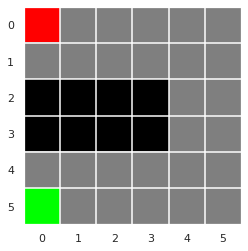

In [12]:

param_agent = {
    "gamma": 0.90,
    "optimizer_LSFM": keras.optimizers.Adam(),
    "optimizer_Q": keras.optimizers.Adam(),
    "alpha_r" : 1.,
    "alpha_N" : 0.1,
    "alpha_psi" : 0.01,
    "policy": {
        "type": ["eps-greedy", "exponantial"],
        "eps-greedy": {
            "exponantial": {
                "eps_max": 1.,
                "eps_min": 0.01,
                "lambda": 0.0002
            },
            "constant": {
                "eps": 0.01
            }
        }
    },
    "memory" : 500000,
    "latent_space": latent_dimension,
    "hidden_dim_ratio": hidden_ratio,
    "num_episodes" : 100,
    "batch_size" : 32,
    "RANDOM_REWARD_STD" : -1.0, 
    "double_model" : True,
    "tau": 0.08,
    "filter_done" : True,
    "train_LSFM" : True,
    "train_on_Q_latent": True,
    "model_Q_Lin": True,
    "train" : True,
    "avg_loss_phisp1" : False,
}

agent = Agent(env, param_agent)


state = env.reset()
env.render()

# actions_down = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
# for i in range(10) : 
#     action = actions_down[i]
#     next_state, reward, done, info = env.step(action)

#     print("action", action)
#     print(" 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right")
# #     print("next_state", next_state)
#     print("reward", reward)
#     print("done", done)
#     env.render()
    
#     state = next_state



In [13]:
def random_action(env) : 
    return random.randint(0, env.action_space.n - 1)

# models summary

## LSFM

Model: "model_LSFM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 36)]         0                                            
__________________________________________________________________________________________________
hidden_latent (Dense)           (None, 30)           1110        input[0][0]                      
__________________________________________________________________________________________________
latent (Dense)                  (None, 30)           930         hidden_latent[0][0]              
__________________________________________________________________________________________________
Fa (Dense)                      (None, 120)          3600        latent[0][0]                     
_________________________________________________________________________________________

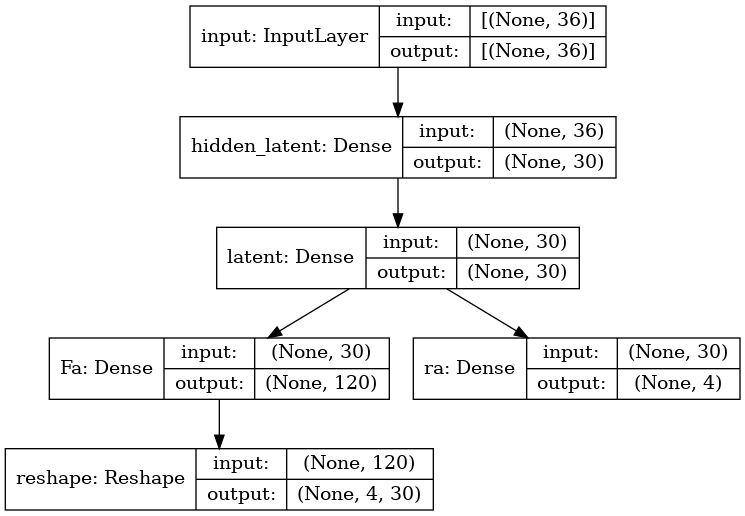

In [14]:
agent.model_LSFM.summary()
keras.utils.plot_model(agent.model_LSFM, "my_first_model.png", show_shapes=True)

## Linear QLearning
Qlearning on latent space

### QLin on latent space

Agent_Q.model : initialization model_Q_Lin
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (32, 4)                   120       
Total params: 120
Trainable params: 120
Non-trainable params: 0
_________________________________________________________________


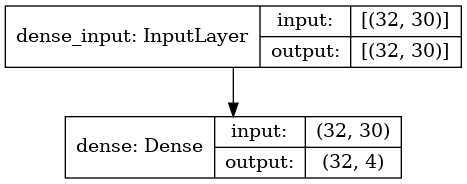

In [15]:
param_agent["model_Q_Lin"] = True

x= np.zeros((param_agent["batch_size"],param_agent["latent_space"]), dtype=float)

agent_Q = Agent_Q(env, param_agent)
agent_Q.model(x)

agent_Q.model.summary()
keras.utils.plot_model(agent_Q.model, "my_first_model_Q.png", show_shapes=True)

### DQN on original space

Agent_Q.model : initialization model_DQN
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent (Dense)               (32, 30)                  1110      
_________________________________________________________________
dense_1 (Dense)              (32, 4)                   124       
Total params: 1,234
Trainable params: 1,234
Non-trainable params: 0
_________________________________________________________________


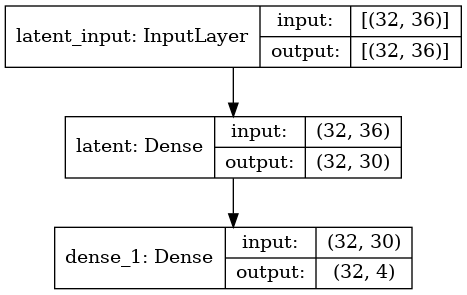

In [16]:
param_agent["model_Q_Lin"] = False

x= np.zeros((param_agent["batch_size"],env._state_dim), dtype=float)

agent_Q = Agent_Q(env, param_agent)
agent_Q.model(x)

agent_Q.model.summary()
keras.utils.plot_model(agent_Q.model, "my_first_model_Q.png", show_shapes=True)

# TESTs agent functions

In [17]:
states_double = np.zeros((2,env._state_dim))
states_double[0,int(env._state_dim*1/3)] = 1
states_double[1,int(env._state_dim*2/3)] = 1

actions_double = np.array([0,1])

states = np.zeros((1,env._state_dim))
states[0,int(env._state_dim*1/3)]  = 1

actions = np.array([0])

states_2 = np.zeros((1,env._state_dim))
states_2[0,int(env._state_dim*2/3)]  = 1 
actions_2 = np.array([1])

## TEST reward 

In [18]:
phi = agent.model_LSFM(states_double)["phi"]
phi[0].shape

TensorShape([30])

In [19]:
for idl, layer in enumerate(agent.model_LSFM.layers):
    name_a = "ra"
    if layer.name == name_a : 
        wa = layer.weights[0]
#         wa = tf.transpose(wa_transpose)

wa.shape, tf.matmul( phi , wa   )

agent.model_LSFM(states_double)["ra"] == tf.matmul( phi , wa   )

# print("wa", wa.shape)
# print("phi", phi.shape)


<tf.Tensor: shape=(2, 4), dtype=bool, numpy=
array([[ True,  True,  True,  True],
       [ True,  True,  True,  True]])>

In [20]:
mse = keras.losses.mean_squared_error

print(mse(tf.matmul( phi , wa   )[:,0]     ,     agent.get_from_actions(states_double,[ 0,0], agent.model_LSFM, "ra")))
print(mse(tf.matmul( phi , wa   )[:,1]      ,      agent.get_from_actions(states_double,[ 1,1], agent.model_LSFM, "ra")))
print(mse(tf.matmul( phi , wa   )[:,2]      ,     agent.get_from_actions(states_double,[ 2,2] , agent.model_LSFM, "ra")))
print(mse(tf.matmul( phi , wa   )[:,3]      ,      agent.get_from_actions(states_double,[ 3,3], agent.model_LSFM, "ra")))


tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)


## psi_bar


In [21]:
agent.get_from_actions(states_double,[ 0,0], agent.model_LSFM, "Fa").shape

TensorShape([2, 30])

In [22]:
agent.model_LSFM(states_double)["Fa"][0,0,:] == agent.get_from_actions(states_double,[ 0,0], agent.model_LSFM, "Fa")[0]
agent.model_LSFM(states_double)["Fa"][1,0,:] == agent.get_from_actions(states_double,[ 0,0], agent.model_LSFM, "Fa")[1]

<tf.Tensor: shape=(30,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])>

In [23]:
for idl, layer in enumerate(agent.model_LSFM.layers):
    name_a = "Fa"
    if layer.name == name_a :         
        Fa = layer.weights[0]

Fa.shape


TensorShape([30, 120])

In [24]:
Fa_reshape = tf.reshape(Fa, (Fa.shape[0],4,Fa.shape[0]))
Fa_reshape.shape

TensorShape([30, 4, 30])

In [25]:
phi = agent.model_LSFM(states_double)["phi"]
phi.shape

TensorShape([2, 30])

In [26]:
psia_scratch = tf.matmul(phi, Fa_reshape[:,0,:])
psia_scratch


<tf.Tensor: shape=(2, 30), dtype=float32, numpy=
array([[ 0.02792404, -0.08547219,  0.02302437, -0.05417609,  0.02101224,
         0.01749489, -0.01586863, -0.07110129, -0.06991991,  0.03269977,
        -0.01250007,  0.04715252,  0.07755696,  0.04505073,  0.10774098,
        -0.0173885 , -0.02274811, -0.10442288, -0.03482389,  0.00998987,
        -0.04621238, -0.0851068 ,  0.01030256, -0.01046882,  0.08233108,
        -0.06053611, -0.02125879, -0.06272335,  0.0546234 ,  0.00678693],
       [-0.02080508,  0.00410759,  0.04679475, -0.07251608, -0.07727857,
         0.04705986,  0.02410084, -0.03004449,  0.02104196, -0.00102587,
        -0.02212099, -0.01634653,  0.02933634,  0.04651838,  0.0204161 ,
        -0.02462942, -0.03586346, -0.01757354,  0.01004527, -0.07088699,
        -0.05571818, -0.04804609,  0.02829167, -0.00188512,  0.04045188,
        -0.06965478,  0.07222785,  0.00296506,  0.06075118, -0.01355513]],
      dtype=float32)>

In [27]:
print(agent.model_LSFM(states_double)["Fa"][:,0,:] == tf.matmul(phi, Fa_reshape[:,0,:]))
print(agent.model_LSFM(states_double)["Fa"][:,1,:] == tf.matmul(phi, Fa_reshape[:,1,:]))
print(agent.model_LSFM(states_double)["Fa"][:,2,:] == tf.matmul(phi, Fa_reshape[:,2,:]))
print(agent.model_LSFM(states_double)["Fa"][:,3,:] == tf.matmul(phi, Fa_reshape[:,3,:]))


tf.Tensor(
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True]], shape=(2, 30), dtype=bool)
tf.Tensor(
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True]], shape=(2, 30), dtype=bool)
tf.Tensor(
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True  True  True  True  True  True  True  True  True
   True  True

In [28]:
def test(a) : 
    return [a+1, a**0.5, (a+1)**0.2]

In [29]:
a = []
for i in range(4) : 
    a.append(test(i))
print("a", a)


b_init = tf.zeros_initializer()
b = tf.Variable(
    initial_value=b_init(shape=(4,3), dtype="float32"))
b.assign(a)

a==b

a [[1, 0.0, 1.0], [2, 1.0, 1.148698354997035], [3, 1.4142135623730951, 1.2457309396155174], [4, 1.7320508075688772, 1.3195079107728942]]


<tf.Tensor: shape=(4, 3), dtype=bool, numpy=
array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])>

In [30]:
b

<tf.Variable 'Variable:0' shape=(4, 3) dtype=float32, numpy=
array([[1.       , 0.       , 1.       ],
       [2.       , 1.       , 1.1486983],
       [3.       , 1.4142135, 1.245731 ],
       [4.       , 1.7320508, 1.319508 ]], dtype=float32)>

In [31]:
b=0
phi[b,:]
phi_unique = tf.reshape(phi[b,:], (1,phi.shape[1]))
phi[b,:].__eq__(phi_unique[0,:])

<tf.Tensor: shape=(30,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])>

In [32]:
psi_batch = []

for b in range(2) : 
    phi_unique = tf.reshape(phi[b,:], (1,phi.shape[1]))
    
    psi_unique = []
    for a in range(4) : 
        res = tf.matmul( phi_unique,Fa_reshape[:,a])
#         print("res", res.shape)
        res_reshape = tf.reshape(res, res.shape[1])
        
        
#         print("res_reshape",res[0,:].__eq__(res_reshape) )
        
        
        
        psi_unique.append(res_reshape)    
    
    
#     b_init = tf.zeros_initializer()
#     test = tf.Variable(
#         initial_value=b_init(shape=(4,phi.shape[1]), dtype="float32"))
    
    
#     test.assign(psi_unique)
    
    test = tf.stack(psi_unique, axis=0)
    
    psi_scratch = tf.convert_to_tensor(psi_unique)
    
#     print("psi_unique", b, psi_unique)
    print("psi", agent.model_LSFM(states_double)["Fa"][b,:,:]== test)
    print("mse",mse(agent.model_LSFM(states_double)["Fa"][b,:,:] , test))
    
    
    print("mse psi_scratch",mse(agent.model_LSFM(states_double)["Fa"][b,:,:] , psi_scratch))
    psi_batch.append(psi_unique)

    
    
    
psi_batch[0][0]

psi tf.Tensor(
[[ True  True False  True False  True  True False False False False  True
  False  True False  True False False  True False  True False  True False
   True False False False False False]
 [ True False False False False  True False  True False False  True False
  False  True False False  True  True False  True False  True False False
  False False False False  True  True]
 [ True False False False False  True  True  True False  True  True False
  False  True False False False  True False  True  True False False  True
  False False False False  True False]
 [ True False False False  True False False False  True False  True  True
   True False False  True  True False  True False  True False False False
   True False False False False False]], shape=(4, 30), dtype=bool)
mse tf.Tensor([1.9486727e-17 1.0299921e-17 6.5774933e-18 8.3555846e-18], shape=(4,), dtype=float32)
mse psi_scratch tf.Tensor([1.9486727e-17 1.0299921e-17 6.5774933e-18 8.3555846e-18], shape=(4,), dtype=float

<tf.Tensor: shape=(30,), dtype=float32, numpy=
array([ 0.02792404, -0.08547219,  0.02302437, -0.05417609,  0.02101224,
        0.01749489, -0.01586863, -0.0711013 , -0.06991992,  0.03269976,
       -0.01250007,  0.04715252,  0.07755697,  0.04505073,  0.10774099,
       -0.0173885 , -0.02274811, -0.10442289, -0.03482389,  0.00998988,
       -0.04621238, -0.08510679,  0.01030256, -0.01046882,  0.08233108,
       -0.06053611, -0.02125878, -0.06272335,  0.0546234 ,  0.00678693],
      dtype=float32)>

In [33]:

    
    
    
# psi_scratch = tf.convert_to_tensor(psi_batch)

# b_init = tf.zeros_initializer()
# b = tf.Variable(
#     initial_value=b_init(shape=(2,4,18), dtype="double"))
# b.assign(psi_batch)

# b


# tf.norm(agent.model_LSFM(states_double)["Fa"]- psi_scratch, axis = 1)

In [34]:
agent.get_from_actions(states_double,[ 0,0], agent.model_LSFM, "Fa").shape

agent.model_LSFM(states_double)["Fa"]
agent.model_LSFM(states_double)["Fa"][0,0,:] == agent.get_from_actions(states_double,[ 0,0], agent.model_LSFM, "Fa")[0]


<tf.Tensor: shape=(30,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])>

## F_bar

In [35]:
F_bar = tf.math.reduce_mean(    Fa_reshape, axis=1 )
F_bar[:,:] == (Fa_reshape[:,0,:] + Fa_reshape[:,1,:] +Fa_reshape[:,2,:] +Fa_reshape[:,3,:] ) / 4
 

<tf.Tensor: shape=(30, 30), dtype=bool, numpy=
array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         Tr

In [36]:

psi = agent.model_LSFM(states_double)["Fa"]



psi_bar = tf.math.reduce_mean(    psi, axis=1 )
psi_bar_scratch = tf.matmul( phi,F_bar)

tf.norm(psi_bar - psi_bar_scratch, axis = 0)
# Fa_reshape.mean()

<tf.Tensor: shape=(30,), dtype=float32, numpy=
array([2.7939675e-09, 3.8399413e-09, 3.8399413e-09, 1.8626450e-09,
       2.0825006e-09, 5.8207661e-10, 9.3132252e-10, 2.3283064e-09,
       3.7252901e-09, 3.7252901e-09, 1.8626450e-09, 3.9512669e-09,
       0.0000000e+00, 1.8626450e-09, 5.2683555e-09, 2.0954756e-09,
       4.1650012e-09, 3.3579308e-09, 2.5076627e-09, 2.6341778e-09,
       3.7252901e-09, 0.0000000e+00, 0.0000000e+00, 2.3283064e-09,
       1.4908436e-09, 1.8626451e-09, 2.7939677e-09, 4.6566129e-09,
       0.0000000e+00, 1.3170890e-09], dtype=float32)>

## filter 

In [37]:


terminate = [ True,  False]

filter_idxs = tf.dtypes.cast(tf.logical_not(terminate), tf.float32)


gamma = 0.9
gamma_psibar = tf.multiply(gamma,psi_bar)

filter_expand  = tf.transpose(tf.tile(
    tf.reshape(filter_idxs, (1,-1) ), [gamma_psibar.shape[1],1]
))


tf.math.multiply(filter_expand, gamma_psibar)

# tf.matmul( gamma_psibar,filter_expand)



<tf.Tensor: shape=(2, 30), dtype=float32, numpy=
array([[-0.        , -0.        , -0.        , -0.        , -0.        ,
         0.        , -0.        , -0.        , -0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.        , -0.        , -0.        ,  0.        ,
         0.        , -0.        , -0.        ,  0.        , -0.        ,
         0.        ,  0.        , -0.        ,  0.        , -0.        ],
       [-0.01682544, -0.00193418, -0.01801527, -0.0017851 ,  0.00558368,
         0.00668716, -0.01988022,  0.00671849,  0.02103568,  0.0265187 ,
         0.01683816, -0.00305755, -0.01249457,  0.01721402,  0.0156653 ,
         0.0028945 ,  0.01103072,  0.01184669,  0.00803155,  0.01387177,
         0.00632466, -0.02076806, -0.01691875, -0.00107312, -0.0005136 ,
         0.01249373,  0.06462634, -0.01311728,  0.02201697,  0.00959124]],
      dtype=float32)>

## test transition function matrice

In [38]:
def plot_matrice(M) : 

    fig, ax = plt.subplots()
    ax.imshow(M)
    dim = M.shape[0]
    # Minor ticks
    ax.set_xticks(np.arange(-.5, dim - 1, 1), minor=True)
    ax.set_yticks(np.arange(-.5, dim - 1, 1), minor=True)

    # Gridlines based on minor ticks
    ax.grid(which='both', color='w', linestyle='-', linewidth=1.5)

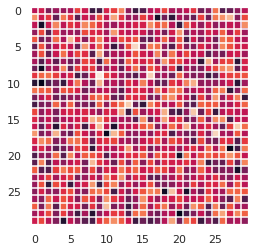

In [39]:
plot_matrice(F_bar)

$$ \boldsymbol{F}_a = \boldsymbol{I} + \gamma  \boldsymbol{M}_a  \overline{\boldsymbol{F}}$$

$$ \dfrac{1}{\gamma} (   \boldsymbol{F}_a  - \boldsymbol{I} )    =  \boldsymbol{M}_a  \overline{\boldsymbol{F}}$$

$$\dfrac{1}{\gamma}  (   \boldsymbol{F}_a  - \boldsymbol{I} )     \overline{\boldsymbol{F}}^{-1}  =  \boldsymbol{M}_a  $$


In [40]:
I = tf.eye(F_bar.shape[0], dtype=tf.dtypes.float32)
gamma = param_agent["gamma"]


In [41]:
M = []
print(" 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right")
for a in range(Fa_reshape.shape[1]) :
    
    MaFbar = 1./gamma * ( Fa_reshape[:,a,:] - I )
    
    Ma = tf.matmul( MaFbar , tf.linalg.inv(F_bar)   )
    
    M.append(Ma)
#     plot_matrice(Fa_reshape[:,a,:]),     plot_matrice(Ma)
M = tf.stack(M, axis=0)
M

 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right


<tf.Tensor: shape=(4, 30, 30), dtype=float32, numpy=
array([[[ -2.1815424 ,  -4.1782126 ,  -7.340476  , ...,  -4.583938  ,
           0.7396907 ,   1.1635486 ],
        [ -6.412883  ,   0.75469416,  -3.4434927 , ...,  -3.495008  ,
           0.32136384,   9.0435    ],
        [ 15.289832  ,   2.8876507 ,  11.046925  , ...,  10.772979  ,
           1.615073  , -11.210656  ],
        ...,
        [  6.8656445 ,   0.12059154,   8.827142  , ...,   3.7142444 ,
           2.4202406 ,  -8.033424  ],
        [ -0.76622325,   0.23199967,  -5.2492557 , ...,  -2.6237137 ,
          -1.1515464 ,   1.9500191 ],
        [  2.0067067 ,   0.2730716 ,   0.19293638, ...,  -2.5517156 ,
           0.78320175,  -0.8703534 ]],

       [[  3.1370537 ,  -1.4683015 ,   0.31134436, ...,  -0.35885724,
           1.8165445 ,  -4.203591  ],
        [  7.51588   ,   3.4353359 ,  11.374504  , ...,   8.788992  ,
           1.7161962 ,  -6.2616863 ],
        [ 15.980637  ,   4.0353913 ,  12.532954  , ...,  11.883793  

In [42]:
M == agent.M_transi(agent.model_LSFM)

<tf.Tensor: shape=(4, 30, 30), dtype=bool, numpy=
array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  Tr

In [43]:
env_name = "SimpleGrid"
env = custom_env(env_name, param_env)

strue =env.reset()
strue   = strue.reshape(1,-1)
phi0 = agent.model_LSFM(strue)["phi"]

a = agent.choose_action_random()[0]
sp1true, rtrue, done, info = env.step(a)

tf.matmul(phi0, M[a]) == agent.next_states_pred(agent.model_LSFM, strue,[a])



<tf.Tensor: shape=(1, 30), dtype=bool, numpy=
array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True]])>

In [44]:

tf.matmul(phi0, M[a]) == agent.next_states_pred(agent.model_LSFM, strue,[a])


<tf.Tensor: shape=(1, 30), dtype=bool, numpy=
array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True]])>

# Train

## environments

### first (puddle word)

action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward -1.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward -1.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward

<ipython-input-4-7239bd9fdfde>:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


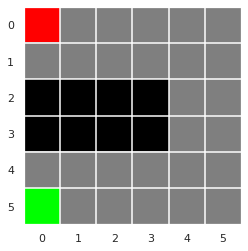

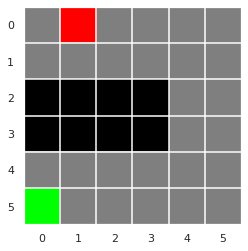

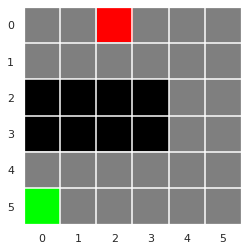

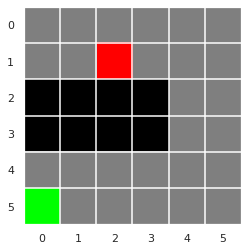

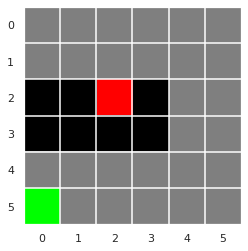

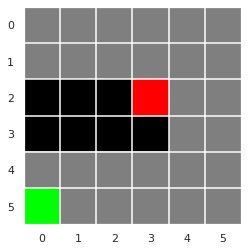

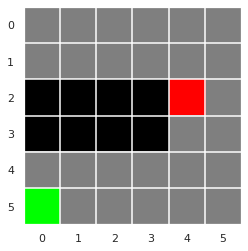

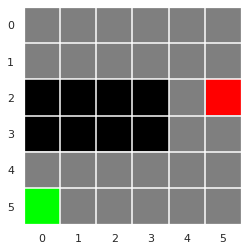

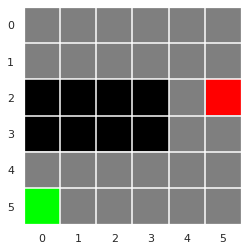

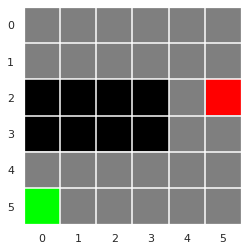

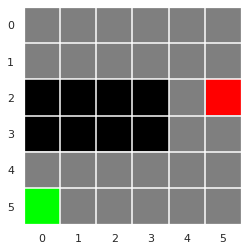

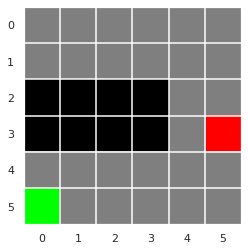

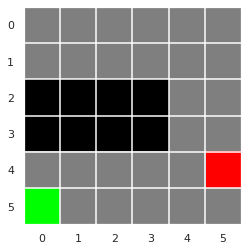

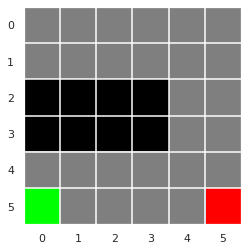

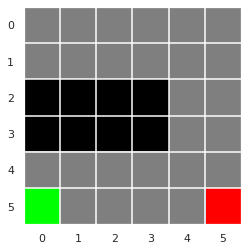

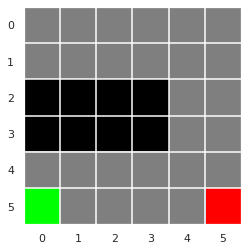

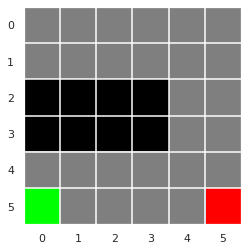

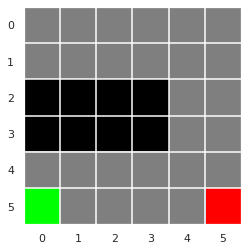

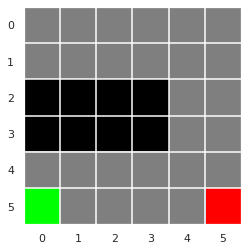

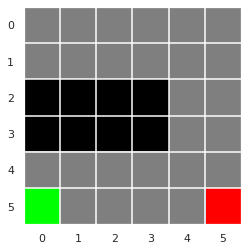

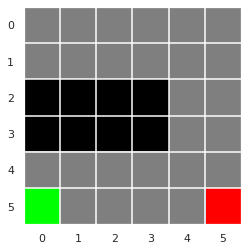

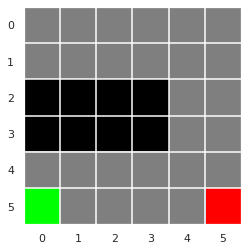

In [45]:

# param_env = {
#     "agent_pos":[0, 0], 
#     "goal_pos":[[10,0] ],
#     "reward_minmax":[-1.,-0.001],
#     "reward_user_defined":True,
#     "reward_pos":[
#         [0, 0],[0, 1],[0, 2],[0, 3],[0, 4],[0, 5],[0, 6],[0, 7],[0, 8],[0, 9],[0, 10],
#         [1, 0],[1, 1],[1, 2],[1, 3],[1, 4],[1, 5],[1, 6],[1, 7],[1, 8],[1, 9],[1, 10],
#                                                                 [2, 8],[2, 9],[2, 10],
#                                                                 [3, 8],[3, 9],[3, 10],
#                                                                 [4, 8],[4, 9],[4, 10],
#                                                                 [5, 8],[5, 9],[5, 10],
#                                                                 [6, 8],[6, 9],[6, 10],
#                                                                 [7, 8],[7, 9],[7, 10],
#                                                                 [8, 8],[8, 9],[8, 10],
#         [9, 0],[9, 1],[9, 2],[9, 3],[9, 4],[9, 5],[9, 6],[9, 7],[9, 8],[9, 9],[9, 10],
#         [10,0],[10,1],[10,2],[10,3],[10,4],[10,5],[10,6],[10,7],[10,8],[10,9],[10,10]
#                 ],
#     "grid_size" : 11,
#     "pattern": "empty",
#     "obs_mode":"index",
# }
param_env = {
    "agent_pos":[0, 0], 
    "goal_pos":[[5,0] ],
    "reward_minmax":[-1.,0.],
    "reward_user_defined":True,
    "reward_pos":[[0, 0],[0, 1],[0, 2],[0, 3],[0, 4],[0, 5], 
                  [1, 0],[1, 1],[1, 2],[1, 3],[1, 4],[1, 5], 
                                              [2, 4],[2, 5], 
                                              [3, 4],[3, 5], 
                  [4, 0],[4, 1],[4, 2],[4, 3],[4, 4],[4, 5], 
                  [5, 0],[5, 1],[5, 2],[5, 3],[5, 4],[5, 5]],
    "grid_size" : 6,
    "pattern": "empty",
    "obs_mode":"index",
}




env_name = "SimpleGrid"
env = custom_env(env_name, param_env)


state = env.reset()
actions_down = [3,3,1,1,3,3,3,3,3,3,1,1,1,1,1,1,1,1,1,3,3,3,3,3]
for i in range(22) : 
    env.render()
    action = actions_down[i]
    next_state, reward, done, info = env.step(action)

    print("action", action)
    print(" 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right")
#     print("next_state", next_state)
    print("reward", reward)
    print("done", done)
    
    state = next_state


### second (four room)

action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 3
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0.0
done False
action 1
 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
reward 0

<ipython-input-4-7239bd9fdfde>:114: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


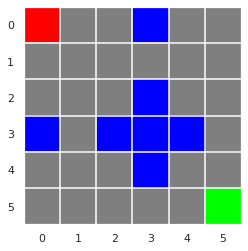

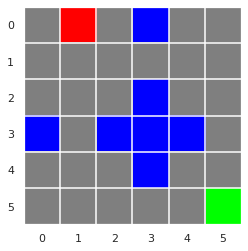

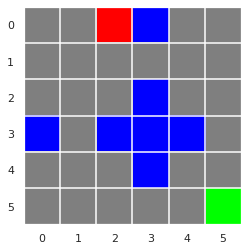

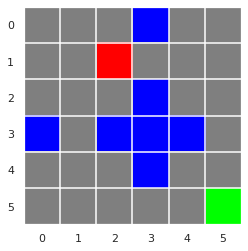

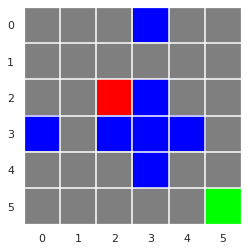

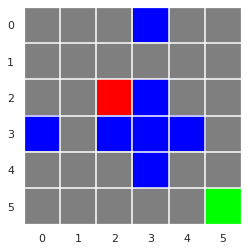

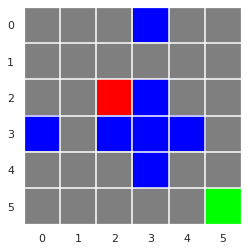

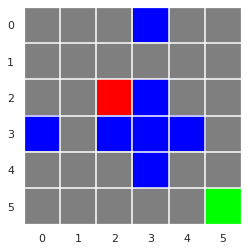

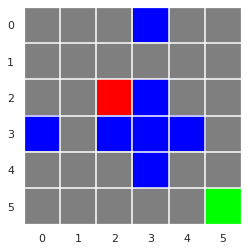

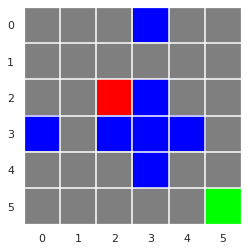

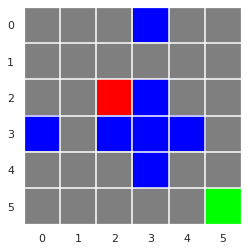

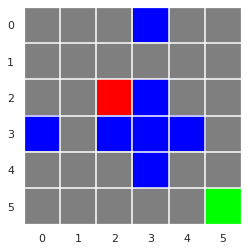

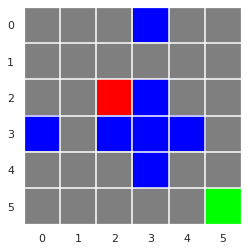

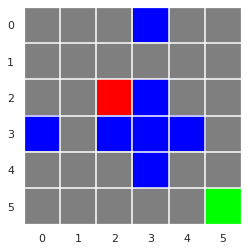

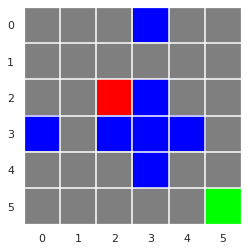

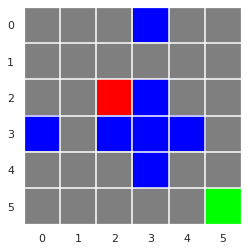

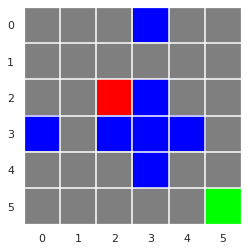

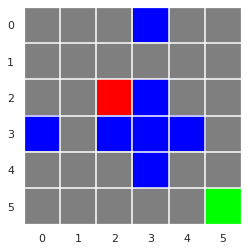

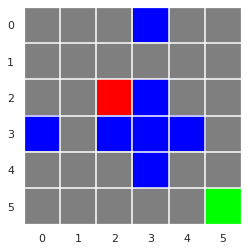

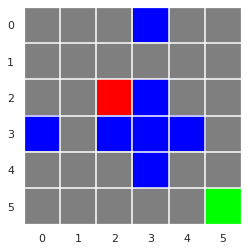

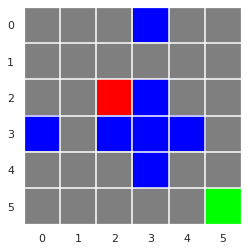

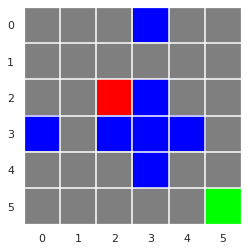

In [46]:
# param_env = {
#     "agent_pos":[0, 0], 
#     "goal_pos":[[10,10] ],
#     "reward_minmax":[0.,0.],
#     "reward_user_defined":False,
#     "reward_pos":None,
#     "grid_size" : 11,
#     "pattern": "four_rooms",
#     "obs_mode":"index",
# }

param_env = {
    "agent_pos":[0, 0], 
    "goal_pos":[[5,5] ],
    "reward_minmax":[0.,0.],
    "reward_user_defined":False,
    "reward_pos":None,
    "grid_size" : 6,
    "pattern": "four_rooms",
    "obs_mode":"index",
}



env_name = "SimpleGrid"
env_change_reward = custom_env(env_name, param_env)


state = env_change_reward.reset()
actions_down = [3,3,1,1,3,3,3,3,3,3,1,1,1,1,1,1,1,1,1,3,3,3,3,3]
for i in range(22) : 
    env_change_reward.render()
    action = actions_down[i]
    next_state, reward, done, info = env_change_reward.step(action)

    print("action", action)
    print(" 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right")
#     print("next_state", next_state)
    print("reward", reward)
    print("done", done)
    
    state = next_state

## functions simulations

In [47]:
def loss_func(ypred, ytrue) : 
#     MSE
#     return keras.losses.mean_squared_error(ypred, ytrue)

#     MAE
    return keras.losses.mean_absolute_error(ypred, ytrue)
    

def simu(env,param_agent,agent_LSFM = None, agent_Q = None, buffer = None, buffer_latent = None) : 
      
    result_compile = []
    steps = 0
    render = param_agent["render"]
    reward_cumul = 0

#     No mask for simple env
    if env.env_name == "SimpleGrid" : 
        action_space = np.arange(env.action_space.n)
        action_no_mask = np.full((env.action_space.n), 1)   
        possible_action = action_space

    
    memory = Memory(param_agent["memory"], buffer)
    memory_latent = Memory(param_agent["memory"], buffer_latent)

    avg_loss = 0
    avg_loss_r  = 0
    avg_loss_N  = 0
    avg_loss_psi  = 0

    
    if agent_LSFM!= None : 
        model_LSFM = agent_LSFM.model_LSFM
        
        ### TRANSITION MATRIX : Calcule the M transition matrix on latent space
        if param_agent["avg_loss_phisp1" ] : 
            agent_LSFM.M_transi(model_LSFM)
        
        
    if agent_Q != None : 
        model_Q = agent_Q.model
        model_Q_prev = agent_Q.model_prev
    
    for i in range(param_agent["num_episodes"]):
        state = env.reset()

        reward_ep_cumul = 0
        cnt = 0
        avg_loss = 0
        
### TRANSITION MATRIX :  Get the prediction error of the next latent space
        loss_phisp1  = 0
        if param_agent["avg_loss_phisp1" ] :         
            phis_pred = model_LSFM(state.reshape(1,-1))["phi"]
        
        while True:
            if render:
                env.render()

                
#             -----------------------------
#             Policy
#             -----------------------------
            if param_agent["train_LSFM"] : 
                action, eps = agent_LSFM.choose_action_random()
                next_state, reward, done, info = env.step(action)
                
                phi_prime = agent_LSFM.model_LSFM(next_state.reshape(1,-1))["phi"]
                next_state_latent = np.array(tf.reshape(phi_prime, phi_prime.shape[-1]))
                
                
            else : 
                if param_agent["train_on_Q_latent"] : 
                    
                    state_resh = state.reshape(1,-1)
                    phi = agent_LSFM.model_LSFM(state_resh)["phi"]
                    state_latent = np.array(tf.reshape(phi, phi.shape[-1]))

                    # eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * steps)
                                        
                    action, eps = agent_Q.choose_action(
                                        state_latent, 
                                        model_Q, 
                                        steps, 
                                        possible_action
                                    )
                    
                    next_state, reward, done, info = env.step(action)

                    next_state_resh = next_state.reshape(1,-1)
                    phi_prime = agent_LSFM.model_LSFM(next_state_resh)["phi"]
                    next_state_latent = np.array(tf.reshape(phi_prime, phi_prime.shape[-1]))

                    
                else : 
                # eps = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * steps)
                    action, eps = agent_Q.choose_action(
                        state, 
                        model_Q, 
                        steps, 
                        possible_action
                    )

                    next_state, reward, done, info = env.step(action)
                    
                    if agent_LSFM!= None : 
                        phi_prime = agent_LSFM.model_LSFM(next_state.reshape(1,-1))["phi"]
                        next_state_latent = np.array(tf.reshape(phi_prime, phi_prime.shape[-1]))

                    
### TRANSITION MATRIX : Get the prediction error of the next latent space
            if param_agent["avg_loss_phisp1"] :                     
                phisp1_pred = agent_LSFM.next_phi_pred(model_LSFM, phis_pred,[action])
                loss_phisp1   += loss_func(phi_prime, phisp1_pred).numpy()[0]
            
#                 print('loss_phisp1', loss_func(phi_prime, phisp1_pred).numpy()[0], loss_phisp1)
            
            if param_agent["RANDOM_REWARD_STD"] > 0:
                reward = np.random.normal(1.0, RANDOM_REWARD_STD)

            reward_ep_cumul += reward
            reward_cumul += reward
            
            if done:
                next_state = np.zeros(env._state_dim)
                next_state_latent = np.zeros(param_agent["latent_space"])
            
            
#             -----------------------------
#             TRAIN
#             -----------------------------
            
            if param_agent["train"] :

                if param_agent["train_LSFM"] : 

                    
                    if buffer == None : 
                        memory.add_sample((state, action_no_mask, action, reward, next_state, done))
                    
                    
                    loss_all = agent_LSFM.train_LSFM(
                        model_LSFM, 
                        memory, 
                        param_agent["filter_done"])

                    avg_loss += loss_all[0]
                    avg_loss_r += loss_all[1]
                    avg_loss_N += loss_all[2]
                    avg_loss_psi += loss_all[3]
                else : 
                    if param_agent["train_on_Q_latent"] : 
                        if buffer_latent == None :
                            memory_latent.add_sample((state_latent,action_no_mask,  action, reward, next_state_latent, done))

                        loss = agent_Q.train_Q(
                        model_Q, 
                        model_Q_prev if param_agent["double_model"] else None,
                        memory_latent, param_agent["filter_done"])
                        avg_loss += loss
                    else :                 
                        memory.add_sample((state,action_no_mask, action, reward, next_state, done))

                        loss = agent_Q.train_Q(
                        model_Q, 
                        model_Q_prev if param_agent["double_model"] else None,
                        memory, param_agent["filter_done"])
                        avg_loss += loss
                
            state = next_state
            
            if param_agent["avg_loss_phisp1"] :                     
                phis_pred = phisp1_pred
                
            steps += 1
            if steps % 1000 == 0 : print("steps : {}, episode : {}, eps : {}".format(steps, i, eps))
#             print("steps : {}, episode : {}".format(steps, i))
            if done:
                
                if cnt != 0:
                    avg_loss /= cnt
                    avg_loss_r /= cnt
                    avg_loss_N /= cnt
                    avg_loss_psi /= cnt
                    loss_phisp1 /= cnt
                    
                else:
                    avg_loss = 0
                    loss_phisp1 = 0
                    
                result = [i, cnt, steps, reward_ep_cumul,
                          reward_cumul, eps, avg_loss, avg_loss_r, avg_loss_N, avg_loss_psi, loss_phisp1]
                if i % 1  == 0 : print(
                    "Episode: {:03d}, step: {:03d}, cumul_step: {:04d}, Reward: {:3.1f}, Reward_cumul: {:3.1f}, eps: {:0.4f}, avg loss: {:0.4f}".format(*result[:-1]))

                result_compile.append(result)
    #             with train_writer.as_default():
    #                 tf.summary.scalar('reward', cnt, step=i)
    #                 tf.summary.scalar('avg loss', avg_loss, step=i)
                break

            cnt += 1
    return result_compile, memory,memory_latent
    
    


In [48]:
def experience(environment, param, agent= None, save_model = None, buffer = None, buffer_latent = None) : 
    
    
    data = pd.DataFrame()
    
    for k in range(param["run"]) : 
                
        agent_Q_simu = Agent_Q(environment, param = param, save_model = save_model)      
        # Restore the weights
#         if save_model != None : 
#             for t in zip(agent_Q_simu.model.trainable_variables):
#                 print("agent_Q_simu", t)

        
        result_compile, memory,memory_latent = simu(environment,param, agent, agent_Q_simu, buffer=buffer,buffer_latent=buffer_latent )
    
    
        memory.write("memory.csv")
        data_train_df = pd.DataFrame(result_compile, columns=[ 
        "Episode", 
        "Step", 
        "cum_step",
        "Reward", 
        "Reward_cum",
        "Eps",  
        "Avg_loss" ,  
        "Avg_loss_r",  
        "Avg_loss_N",  
        "Avg_loss_psi", "Avg_loss_phi"])

        data_train_df["carac"] = carac_model(param) 
        data_train_df["run"] = k
        data = pd.concat([data, data_train_df])

    return data, agent_Q_simu

## function plot

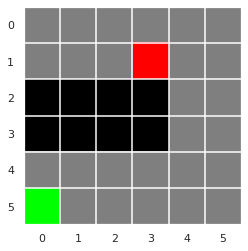

In [49]:
import numpy as geek
def render_state(state) : 


    dim2D = int(state.shape[0]**0.5)
    state = state.reshape(dim2D, dim2D).astype(int)
    out_tpl = geek.nonzero(state)
    pos = [out_tpl[0][0], out_tpl[1][0]]

    env.render_state(pos)

state = np.zeros((env._state_dim))
state[9]  = 1
render_state(state)

In [50]:
# def render(env,state)

#     fig, ax = plt.subplots()
#                 ax.imshow(self.env.grid)

#                 # Minor ticks
#                 ax.set_xticks(np.arange(-.5, (self._state_dim)**0.5 - 1, 1), minor=True)
#                 ax.set_yticks(np.arange(-.5, (self._state_dim)**0.5 - 1, 1), minor=True)

#                 # Gridlines based on minor ticks
#                 ax.grid(which='both', color='w', linestyle='-', linewidth=1.5)

In [51]:
def plot_stat(data, param , col) : 
    stat = []
    stat_all = []
    for episode in range(param["num_episodes"]) : 

        mean = data.loc[lambda df: df['Episode'] == episode][col].mean()
        quantile10 = data.loc[lambda df: df['Episode'] == episode][col].quantile(0.1)
        quantile90 = data.loc[lambda df: df['Episode'] == episode][col].quantile(0.9)
        
        stat_all.append(data.loc[lambda df: df['Episode'] == episode][col].values   )

        stat.append([mean, quantile10, quantile90])
        
    data_stat = pd.DataFrame(stat, columns=[ "mean", "quantile10","quantile90"]     )
    


    # set seaborn style
    sns.set_theme()

    # Data
    x=range(param_agent_simu["num_episodes"])
    y=[ data_stat["quantile10"], data_stat["mean"], data_stat["quantile90"]]

    # Plot
    plt.stackplot(x,y, labels=['quantile10','mean','quantile90'])
    plt.legend(loc='upper left')
    plt.show()
    
    
    return data_stat, np.array(stat_all)

In [52]:
def box_plot(data,param, col) : 


    data_Q_episode_par_10 = pd.DataFrame()


    for k in range(0,param["num_episodes"], 10) : 
        data_Q_episode_par_10 = pd.concat([data_Q_episode_par_10,
                                          data.loc[lambda df: df['Episode'] == k]])


    fig, axs = plt.subplots(1, 1,figsize=(15, 5))
    sns.boxplot( x=data_Q_episode_par_10["Episode"], y=data_Q_episode_par_10[col] )
    
    return data_Q_episode_par_10

In [53]:
def carac_model(param) : 
    if param["train_LSFM"] : calcul = "LSFM"
    else : 
        if param["train_on_Q_latent"]  : calcul = "Q_latent"
        else : calcul = "Q"
        if param["model_Q_Lin"]  : calcul+="_Lin"
        else : calcul+="_Deep"
    
    return calcul

## Train LSFM on random policy

### train

In [54]:
param_agent = {
    "gamma": 0.90,
    "optimizer_LSFM": keras.optimizers.Adam(),
    "optimizer_Q": keras.optimizers.Adam(),
    "alpha_r" : 1.,
    "alpha_N" : 0.1,
    "alpha_psi" : 0.1,
    "policy": {
        "type": ["eps-greedy", "exponantial"],
        "eps-greedy": {
            "exponantial": {
                "eps_max": 1.,
                "eps_min": 0.01,
                "lambda": 0.0005
            },
            "constant": {
                "eps": 0.01
            }
        }
    },
    "memory" : 500000,
    "latent_space": latent_dimension,
    "hidden_dim_ratio": hidden_ratio,
    "num_episodes" : 10,
    "batch_size" : 32,
    "RANDOM_REWARD_STD" : -1.0, 
    "double_model" : True,
    "tau": 0.08,
    "filter_done" : True,
    "train_LSFM" : True,
    "train_on_Q_latent": True,
    "model_Q_Lin": True,
    "train" : True,
    "render": False,
    "run": 15,
    "avg_loss_phisp1" : False,
    
}

In [55]:
%%time
# choice of environement  : 
environment = env
param_agent_simu = {}
param_agent_simu = param_agent.copy()
param_agent_simu["run"] = 1
param_agent_simu["num_episodes"] = 10
param_agent_simu["double_model"] = False

params = {
#     "alpha_N" : [1e-1, 1e0],
#     "alpha_psi" : [1e-2, 1e-1, 1e0]
    "alpha_N" : [1e0],
    "alpha_psi" : [1e-1]
}




# load LSFM model : 
agent = Agent(env, param_agent_simu)

# initialisation data
data = pd.DataFrame()
        
# launch experience of simulations
data, agent_Q = experience(environment, param_agent_simu, agent)

Agent_Q.model : initialization model_Q_Lin
Episode: 000, step: 305, cumul_step: 0306, Reward: -46.0, Reward_cumul: -46.0, eps: 1.0000, avg loss: 0.1177
Episode: 001, step: 090, cumul_step: 0397, Reward: -11.0, Reward_cumul: -57.0, eps: 1.0000, avg loss: 0.1014
Episode: 002, step: 017, cumul_step: 0415, Reward: -2.0, Reward_cumul: -59.0, eps: 1.0000, avg loss: 0.1046
Episode: 003, step: 562, cumul_step: 0978, Reward: -128.0, Reward_cumul: -187.0, eps: 1.0000, avg loss: 0.0701
steps : 1000, episode : 4, eps : 1.0
Episode: 004, step: 153, cumul_step: 1132, Reward: -32.0, Reward_cumul: -219.0, eps: 1.0000, avg loss: 0.0363
Episode: 005, step: 025, cumul_step: 1158, Reward: -2.0, Reward_cumul: -221.0, eps: 1.0000, avg loss: 0.0332
Episode: 006, step: 050, cumul_step: 1209, Reward: -9.0, Reward_cumul: -230.0, eps: 1.0000, avg loss: 0.0347
Episode: 007, step: 184, cumul_step: 1394, Reward: -14.0, Reward_cumul: -244.0, eps: 1.0000, avg loss: 0.0285
Episode: 008, step: 066, cumul_step: 1461, Re

In [56]:
data

,Episode,Step,cum_step,Reward,Reward_cum,Eps,Avg_loss,Avg_loss_r,Avg_loss_N,Avg_loss_psi,Avg_loss_phi,carac,run
0,0,305,306,-46.0,-46.0,1.0,0.117728,0.103586,0.084669,0.056752,0.0,LSFM,0
1,1,90,397,-11.0,-57.0,1.0,0.101409,0.090063,0.024500,0.102043,0.0,LSFM,0
2,2,17,415,-2.0,-59.0,1.0,0.104638,0.096127,0.035850,0.109680,0.0,LSFM,0
3,3,562,978,-128.0,-187.0,1.0,0.070051,0.055872,0.059887,0.083872,0.0,LSFM,0
4,4,153,1132,-32.0,-219.0,1.0,0.036280,0.023280,0.058093,0.076491,0.0,LSFM,0
5,5,25,1158,-2.0,-221.0,1.0,0.033209,0.021184,0.055712,0.079234,0.0,LSFM,0
6,6,50,1209,-9.0,-230.0,1.0,0.034652,0.022007,0.053820,0.079571,0.0,LSFM,0
7,7,184,1394,-14.0,-244.0,1.0,0.028503,0.016778,0.045138,0.074027,0.0,LSFM,0
8,8,66,1461,-4.0,-248.0,1.0,0.024427,0.014010,0.036109,0.072413,0.0,LSFM,0
9,9,117,1579,-33.0,-281.0,1.0,0.022760,0.011946,0.036037,0.074228,0.0,LSFM,0


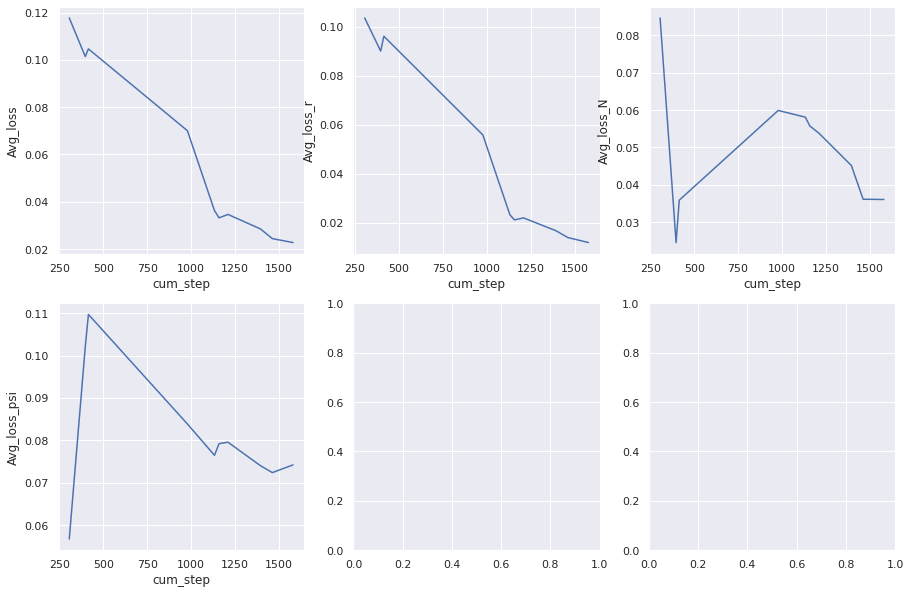

<Figure size 360x360 with 0 Axes>

avg_loss 0.022759766206463687
avg_loss_r 0.011945699297801551
avg_loss_N 0.03603744320914144
avg_loss_psi 0.07422819669412212


In [57]:
df = data

fig, axs = plt.subplots(2, 3,figsize=(15, 10))
plt.figure(figsize=(5, 5))
sns.lineplot(x="cum_step", y="Avg_loss", data=df, ax = axs[0,0] )
sns.lineplot(x="cum_step", y="Avg_loss_r", data=df, ax = axs[0,1] )
sns.lineplot(x="cum_step", y="Avg_loss_N", data=df, ax = axs[0,2] )
sns.lineplot(x="cum_step", y="Avg_loss_psi", data=df, ax = axs[1,0] )
plt.show()

eval_step = int(param_agent_simu["num_episodes"] - param_agent_simu["num_episodes"] /10)

avg_loss = df.loc[eval_step:,"Avg_loss"].mean()
avg_loss_r = df.loc[eval_step:,"Avg_loss_r"].mean()
avg_loss_N = df.loc[eval_step:,"Avg_loss_N"].mean()
avg_loss_psi = df.loc[eval_step:,"Avg_loss_psi"].mean()

print("avg_loss", avg_loss)
print("avg_loss_r", avg_loss_r)
print("avg_loss_N", avg_loss_N)
print("avg_loss_psi", avg_loss_psi)

In [58]:
# %%time


# from itertools import product


# param_agent_simu = {}
# param_agent_simu = param_agent.copy()
# param_agent_simu["run"] = 10
# param_agent_simu["double_model"] = False




# params = {
#     "alpha_N" : [1e-2,1e-1, 1e0],
#     "alpha_psi" : [1e-2, 1e-1, 1e0]
# #     "alpha_N" : [1e-1],
# #     "alpha_psi" : [1e-2]
# }
# combi_params = [dict(zip(params, v)) for v in product(*params.values())]

# results = []

# data_LSFM = pd.DataFrame()

# for params in combi_params : 
    
        
    
#     for key, value in params.items():
#         param_agent_simu[key] = value
    
#     for k in range(param_agent_simu["run"]) : 
#         param_agent_simu["reset_LSFM"] = True
        
        
#         agent = Agent(env, param_agent_simu)

#         result_compile = simu(env,param_agent_simu,agent) 
        
#         data_train_df = pd.DataFrame(result_compile, columns=[ 
#         "Episode", 
#         "Step", 
#         "cum_step",
#         "Reward", 
#         "Reward_cum",
#         "Eps",  
#         "Avg_loss" ,  
#         "Avg_loss_r",  
#         "Avg_loss_N",  
#         "Avg_loss_psi"])



#         data_train_df["carac"] = carac_model(param_agent_simu) 
#         data_train_df["param"] = str(params)    
#         data_LSFM = pd.concat([data_LSFM, data_train_df])

#         eval_step = int(param_agent_simu["num_episodes"] - param_agent_simu["num_episodes"] /10)

        

#         avg_loss = data_train_df.loc[eval_step:,"Avg_loss"].mean()
#         avg_loss_r = data_train_df.loc[eval_step:,"Avg_loss_r"].mean()
#         avg_loss_N = data_train_df.loc[eval_step:,"Avg_loss_N"].mean()
#         avg_loss_psi = data_train_df.loc[eval_step:,"Avg_loss_psi"].mean()

#         print("avg_loss", avg_loss)
#         print("avg_loss_r", avg_loss_r)
#         print("avg_loss_N", avg_loss_N)
#         print("avg_loss_psi", avg_loss_psi)

#         results.append([avg_loss,avg_loss_r, avg_loss_N,avg_loss_psi , str(params)   ])
    

# results


# # data_results = pd.DataFrame(results, columns=[ "Avg_loss", "Avg_loss_r","Avg_loss_N", "Avg_loss_psi", params ]     )

### eval the error on random sequence action

In [59]:
# data_results = pd.DataFrame(results, columns=[ "Avg_loss", "Avg_loss_r","Avg_loss_N", "Avg_loss_psi", "params" ]     )

In [60]:
# data_results = pd.DataFrame(results, columns=[ "Avg_loss", "Avg_loss_r","Avg_loss_N", "Avg_loss_psi", "params" ]     )
# col = "Avg_loss"
# df = data_results
# fig, axs = plt.subplots(1, 1,figsize=(10, 5))
# sns.boxplot( x=df["params"], y=df[col] )
# axs.set_xticklabels(df["params"].unique(),  rotation=30, ha= 'right');
# plt.ylim(0, 0.0001)

### train LSFM on best parameters

In [61]:
# data_LSFM.to_csv('data_LSFM.csv')

In [62]:
# data_results.to_csv('data_results.csv')

In [63]:
# %%time


# from itertools import product


# param_agent_simu = {}
# param_agent_simu = param_agent.copy()
# param_agent_simu["run"] = 1
# param_agent_simu["num_episodes"] = 400
# param_agent_simu["double_model"] = False

# params = {
# #     "alpha_N" : [1e-1, 1e0],
# #     "alpha_psi" : [1e-2, 1e-1, 1e0]
#     "alpha_N" : [1e0],
#     "alpha_psi" : [1e-1]
# }
# combi_params = [dict(zip(params, v)) for v in product(*params.values())]

# results_best = []

# data_LSFM_best = pd.DataFrame()

# for params in combi_params : 
    
#     for key, value in params.items():
#         param_agent_simu[key] = value
    
#     for k in range(param_agent_simu["run"]) : 
#         param_agent_simu["reset_LSFM"] = True
        
        
        
#         agent = Agent(env, param_agent_simu)
#         result_compile , memory,memory_latent= simu(env,param_agent_simu,agent) 
        
#         data_train_df = pd.DataFrame(result_compile, columns=[ 
#         "Episode", 
#         "Step", 
#         "cum_step",
#         "Reward", 
#         "Reward_cum",
#         "Eps",  
#         "Avg_loss" ,  
#         "Avg_loss_r",  
#         "Avg_loss_N",  
#         "Avg_loss_psi",
#         "Avg_loss_phi"        
#         ])



#         data_train_df["carac"] = carac_model(param_agent_simu) 
#         data_train_df["param"] = str(params)    
#         data_LSFM_best = pd.concat([data_LSFM_best, data_train_df])

#         eval_step = int(param_agent_simu["num_episodes"] - param_agent_simu["num_episodes"] /10)

        
        
        
        
#         fig, axs = plt.subplots(2, 3,figsize=(15, 10))
#         plt.figure(figsize=(5, 5))
#         sns.lineplot(x="cum_step", y="Avg_loss", data=data_train_df, ax = axs[0,0] )
#         sns.lineplot(x="cum_step", y="Avg_loss_r", data=data_train_df, ax = axs[0,1] )
#         sns.lineplot(x="cum_step", y="Avg_loss_N", data=data_train_df, ax = axs[0,2] )
#         sns.lineplot(x="cum_step", y="Avg_loss_psi", data=data_train_df, ax = axs[1,0] )
#         plt.show()

#         avg_loss = data_train_df.loc[eval_step:,"Avg_loss"].mean()
#         avg_loss_r = data_train_df.loc[eval_step:,"Avg_loss_r"].mean()
#         avg_loss_N = data_train_df.loc[eval_step:,"Avg_loss_N"].mean()
#         avg_loss_psi = data_train_df.loc[eval_step:,"Avg_loss_psi"].mean()

#         print("avg_loss", avg_loss)
#         print("avg_loss_r", avg_loss_r)
#         print("avg_loss_N", avg_loss_N)
#         print("avg_loss_psi", avg_loss_psi)

#         results_best.append([avg_loss,avg_loss_r, avg_loss_N,avg_loss_psi , str(params)   ])
    

# results_best





In [64]:
# data_train_df

## __SAVE__ LSFM in './agent_LSFM_model'

In [65]:

agent.model_LSFM.save( folder_WORK+"/agent_LSFM_model")

INFO:tensorflow:Assets written to: LSFM_V2.5_dim1.2-hidden_ratio_12021-06-10_09h-31m-27s/agent_LSFM_model/assets


In [66]:

# plt.figure(figsize=(5, 5))
# sns.lineplot(x="cum_step", y="Avg_loss", data=data_train_df, label="Avg_loss" )
# sns.lineplot(x="cum_step", y="Avg_loss_r", data=data_train_df, label="Avg_loss_r" )
# sns.lineplot(x="cum_step", y="Avg_loss_N", data=data_train_df , label="Avg_loss_N")
# sns.lineplot(x="cum_step", y="Avg_loss_psi", data=data_train_df , label="Avg_loss_psi")
# plt.legend()

# plt.savefig(folder_WORK+"/"+dt_string+"loss_LSFM.jpg")
# plt.show()

In [67]:

# param_agent_simu = {}
# param_agent_simu = param_agent.copy()

# load LSFM model : 
agent = Agent(env, param_agent_simu)
agent.model_LSFM = keras.models.load_model(folder_WORK+'/agent_LSFM_model')

model = agent.model_LSFM
for i in range(len(model.layers)):
    print("layers name",i,  model.layers[i].name)
    
aux_model_LSFM = tf.keras.Model(inputs=model.inputs,
           outputs=[model.layers[2].output])


layers name 0 input
layers name 1 hidden_latent
layers name 2 latent
layers name 3 Fa
layers name 4 reshape_1
layers name 5 ra


In [68]:

# state = env.reset()

# n = env._state_dim  
# # param_env["grid_size"]*param_env["grid_size"]

# states = []
# for i in range(n) :
#     state = np.array(keras.utils.to_categorical(i,num_classes=n)).reshape(n)
#     states.append(state)

    
# states = np.array(states)
# phi = agent.model_LSFM(states)["phi"]

# aux_model_LSFM(states) == phi


In [69]:
# # choice of environement  : 
# environment = env

# # parameters of simulation : 

# param_agent_simu = {}
# param_agent_simu = param_agent.copy()

# param_agent_simu["train_LSFM"] = False
# param_agent_simu["double_model"] = True
# param_agent_simu["train_on_Q_latent"] = False
# param_agent_simu["model_Q_Lin"] = False
# param_agent_simu["run"] =  5
# param_agent_simu["policy"]["eps-greedy"]["exponantial"]["lambda"] =  0.0002


# agent_Q_simu = Agent_Q(environment, param = param_agent_simu, save_model = './agent_Q_model') 

# model = agent_Q_simu.model
# for i in range(len(model.layers)):
#     print("layers name",i,  model.layers[i].name)
    
# aux_model_Q = tf.keras.Model(inputs=model.inputs,
#            outputs=[model.layers[0].output])

In [70]:
# states = []
# for i in range(n) :
#     state = np.array(keras.utils.to_categorical(i,num_classes=n)).reshape(n)
#     states.append(state)

    
# states = np.array(states)
# phi_Q = aux_model_Q(states)


# aux_model_Q(states) == phi_Q


## Q-learning

### Linear Q-learning on LSFM latent space


 Train Q-function on __latent reward-predictive state space__ and on the _optimal policy_ to _maximize the dicounted sum of rewards_

#### original environment

In [71]:
param_agent

{'gamma': 0.9,
 'optimizer_LSFM': <tensorflow.python.keras.optimizer_v2.adam.Adam at 0x7fc418c551f0>,
 'optimizer_Q': <tensorflow.python.keras.optimizer_v2.adam.Adam at 0x7fc418c55730>,
 'alpha_r': 1.0,
 'alpha_N': 0.1,
 'alpha_psi': 0.1,
 'policy': {'type': ['eps-greedy', 'exponantial'],
  'eps-greedy': {'exponantial': {'eps_max': 1.0,
    'eps_min': 0.01,
    'lambda': 0.0005},
   'constant': {'eps': 0.01}}},
 'memory': 500000,
 'latent_space': 30,
 'hidden_dim_ratio': 1.0,
 'num_episodes': 10,
 'batch_size': 32,
 'RANDOM_REWARD_STD': -1.0,
 'double_model': True,
 'tau': 0.08,
 'filter_done': True,
 'train_LSFM': True,
 'train_on_Q_latent': True,
 'model_Q_Lin': True,
 'train': True,
 'render': False,
 'run': 15,
 'avg_loss_phisp1': False}

In [72]:
%%time
# choice of environement  : 
environment = env

# parameters of simulation : 
param_agent_simu = {}
param_agent_simu = param_agent.copy()

param_agent_simu["train_LSFM"] = False
param_agent_simu["double_model"] = True
param_agent_simu["train_on_Q_latent"] = True
param_agent_simu["model_Q_Lin"] = True
param_agent_simu["run"] =  5
param_agent_simu["policy"]["eps-greedy"]["exponantial"]["lambda"] =  0.0001
# param_agent_simu["render"] =  False




# load LSFM model : 
agent = Agent(env, param_agent_simu)
agent.model_LSFM = keras.models.load_model(folder_WORK+'/agent_LSFM_model')

# initialisation data
data = pd.DataFrame()
        
# launch experience of simulations
data, agent_Q = experience(environment, param_agent_simu, agent)




Agent_Q.model : initialization model_Q_Lin
Episode: 000, step: 385, cumul_step: 0386, Reward: -100.0, Reward_cumul: -100.0, eps: 0.9626, avg loss: 0.0373
Episode: 001, step: 190, cumul_step: 0577, Reward: -100.0, Reward_cumul: -200.0, eps: 0.9446, avg loss: 0.0249
Episode: 002, step: 008, cumul_step: 0586, Reward: -3.0, Reward_cumul: -203.0, eps: 0.9437, avg loss: 0.0197
Episode: 003, step: 086, cumul_step: 0673, Reward: -9.0, Reward_cumul: -212.0, eps: 0.9357, avg loss: 0.0192
steps : 1000, episode : 4, eps : 0.9058786272390801
Episode: 004, step: 451, cumul_step: 1125, Reward: -69.0, Reward_cumul: -281.0, eps: 0.8947, avg loss: 0.0098
Episode: 005, step: 292, cumul_step: 1418, Reward: -42.0, Reward_cumul: -323.0, eps: 0.8692, avg loss: 0.0054
Episode: 006, step: 016, cumul_step: 1435, Reward: -2.0, Reward_cumul: -325.0, eps: 0.8677, avg loss: 0.0051
Episode: 007, step: 076, cumul_step: 1512, Reward: -6.0, Reward_cumul: -331.0, eps: 0.8612, avg loss: 0.0041
Episode: 008, step: 480, cu

In [73]:

data_Q_lat_state  = data.copy()
data_Q_lat_state

,Episode,Step,cum_step,Reward,Reward_cum,Eps,Avg_loss,Avg_loss_r,Avg_loss_N,Avg_loss_psi,Avg_loss_phi,carac,run
0,0,385,386,-100.0,-100.0,0.962609,0.037280,0.0,0.0,0.0,0.0,Q_latent_Lin,0
1,1,190,577,-100.0,-200.0,0.944587,0.024916,0.0,0.0,0.0,0.0,Q_latent_Lin,0
2,2,8,586,-3.0,-203.0,0.943746,0.019688,0.0,0.0,0.0,0.0,Q_latent_Lin,0
3,3,86,673,-9.0,-212.0,0.935658,0.019233,0.0,0.0,0.0,0.0,Q_latent_Lin,0
4,4,451,1125,-69.0,-281.0,0.894750,0.009779,0.0,0.0,0.0,0.0,Q_latent_Lin,0
5,5,292,1418,-42.0,-323.0,0.869203,0.005426,0.0,0.0,0.0,0.0,Q_latent_Lin,0
6,6,16,1435,-2.0,-325.0,0.867743,0.005100,0.0,0.0,0.0,0.0,Q_latent_Lin,0
7,7,76,1512,-6.0,-331.0,0.861164,0.004131,0.0,0.0,0.0,0.0,Q_latent_Lin,0
8,8,480,1993,-40.0,-371.0,0.821192,0.003225,0.0,0.0,0.0,0.0,Q_latent_Lin,0
9,9,65,2059,-3.0,-374.0,0.815856,0.002298,0.0,0.0,0.0,0.0,Q_latent_Lin,0


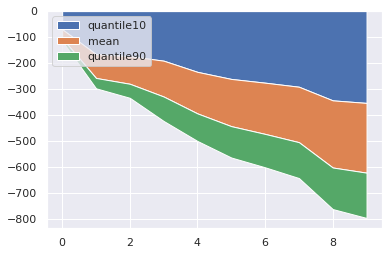

,Episode,Step,cum_step,Reward,Reward_cum,Eps,Avg_loss,Avg_loss_r,Avg_loss_N,Avg_loss_psi,Avg_loss_phi,carac,run
0,0,385,386,-100.0,-100.0,0.962609,0.03728,0.0,0.0,0.0,0.0,Q_latent_Lin,0
0,0,40,41,-12.0,-12.0,0.996048,0.00000,0.0,0.0,0.0,0.0,Q_latent_Lin,1
0,0,133,134,-21.0,-21.0,0.986920,0.01315,0.0,0.0,0.0,0.0,Q_latent_Lin,2
0,0,17,18,-11.0,-11.0,0.998318,0.00000,0.0,0.0,0.0,0.0,Q_latent_Lin,3
0,0,68,69,-27.0,-27.0,0.993291,0.00000,0.0,0.0,0.0,0.0,Q_latent_Lin,4


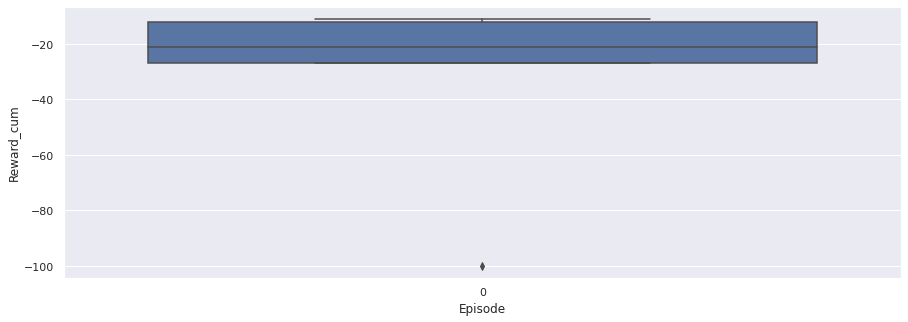

In [74]:
data_stat, stat_all = plot_stat(data, param_agent_simu , "Reward_cum")
box_plot(data, param_agent_simu, "Reward_cum")

#### change in environment rewards

#### a refaire avec ["lambda"] =  0.0002

In [75]:
%%time

# choice of environement  : 
environment = env_change_reward

# parameters of simulation : 
param_agent_simu = {}
param_agent_simu = param_agent.copy()

param_agent_simu["train_LSFM"] = False
param_agent_simu["double_model"] = True
param_agent_simu["train_on_Q_latent"] = True
param_agent_simu["model_Q_Lin"] = True
param_agent_simu["run"] =  5
param_agent_simu["policy"]["eps-greedy"]["exponantial"]["lambda"] =  0.0005


# load LSFM model : 
agent = Agent(env, param_agent_simu)
agent.model_LSFM = keras.models.load_model(folder_WORK+'/agent_LSFM_model')

# initialisation data
data = pd.DataFrame()
        
# launch experience of simulations
data, agent_Q = experience(environment, param_agent_simu, agent)




Agent_Q.model : initialization model_Q_Lin
Episode: 000, step: 285, cumul_step: 0286, Reward: 1.0, Reward_cumul: 1.0, eps: 0.8685, avg loss: 0.0022
Episode: 001, step: 088, cumul_step: 0375, Reward: 1.0, Reward_cumul: 2.0, eps: 0.8311, avg loss: 0.0011
Episode: 002, step: 074, cumul_step: 0450, Reward: 1.0, Reward_cumul: 3.0, eps: 0.8009, avg loss: 0.0009
Episode: 003, step: 192, cumul_step: 0643, Reward: 1.0, Reward_cumul: 4.0, eps: 0.7282, avg loss: 0.0008
Episode: 004, step: 075, cumul_step: 0719, Reward: 1.0, Reward_cumul: 5.0, eps: 0.7014, avg loss: 0.0007
Episode: 005, step: 055, cumul_step: 0775, Reward: 1.0, Reward_cumul: 6.0, eps: 0.6823, avg loss: 0.0006
steps : 1000, episode : 6, eps : 0.6107656608627453
Episode: 006, step: 319, cumul_step: 1095, Reward: 1.0, Reward_cumul: 7.0, eps: 0.5829, avg loss: 0.0006
Episode: 007, step: 081, cumul_step: 1177, Reward: 1.0, Reward_cumul: 8.0, eps: 0.5599, avg loss: 0.0006
Episode: 008, step: 262, cumul_step: 1440, Reward: 1.0, Reward_cu

In [76]:

data_Q_lat_state_change  = data.copy()
data_Q_lat_state_change

,Episode,Step,cum_step,Reward,Reward_cum,Eps,Avg_loss,Avg_loss_r,Avg_loss_N,Avg_loss_psi,Avg_loss_phi,carac,run
0,0,285,286,1.0,1.0,0.868516,0.002212,0.0,0.0,0.0,0.0,Q_latent_Lin,0
1,1,88,375,1.0,2.0,0.831149,0.001104,0.0,0.0,0.0,0.0,Q_latent_Lin,0
2,2,74,450,1.0,3.0,0.800926,0.000901,0.0,0.0,0.0,0.0,Q_latent_Lin,0
3,3,192,643,1.0,4.0,0.728169,0.000754,0.0,0.0,0.0,0.0,Q_latent_Lin,0
4,4,75,719,1.0,5.0,0.701391,0.000655,0.0,0.0,0.0,0.0,Q_latent_Lin,0
5,5,55,775,1.0,6.0,0.682300,0.000571,0.0,0.0,0.0,0.0,Q_latent_Lin,0
6,6,319,1095,1.0,7.0,0.582896,0.000639,0.0,0.0,0.0,0.0,Q_latent_Lin,0
7,7,81,1177,1.0,8.0,0.559883,0.000604,0.0,0.0,0.0,0.0,Q_latent_Lin,0
8,8,262,1440,1.0,9.0,0.492126,0.000563,0.0,0.0,0.0,0.0,Q_latent_Lin,0
9,9,314,1755,1.0,10.0,0.421869,0.000496,0.0,0.0,0.0,0.0,Q_latent_Lin,0


In [77]:
# %%time
# param_agent_simu = {}
# param_agent_simu = param_agent.copy()

# param_agent_simu["train_LSFM"] = False
# param_agent_simu["double_model"] = True
# param_agent_simu["train_on_Q_latent"] = True
# param_agent_simu["model_Q_Lin"] = True
# param_agent_simu["policy"]["eps-greedy"]["exponantial"]["lambda"]=0.0005

# param_agent_simu["reset_Q_model"] =  False
# param_agent_simu["run"] =  5

# param_agent_simu["reset_LSFM"] =  False

# data = pd.DataFrame()

# model_Q_copy = None
# environment = env_change_reward

# for k in range(param_agent_simu["run"]) : 
#     if model_Q_copy == None: 
#         agent_Q = Agent_Q(environment, param_agent)
#         result_compile = simu(environment,param_agent_simu, agent, agent_Q)
#     else : 
#         agent_Q_simu = Agent_Q(environment, param_agent , modelclone = model_Q_copy)
#         result_compile = simu(environment,param_agent_simu, agent, agent_Q_simu)
    
#     data_train_df = pd.DataFrame(result_compile, columns=[ 
#     "Episode", 
#     "Step", 
#     "cum_step",
#     "Reward", 
#     "Reward_cum",
#     "Eps",  
#     "Avg_loss" ,  
#     "Avg_loss_r",  
#     "Avg_loss_N",  
#     "Avg_loss_psi"])

#     data_train_df["carac"] = carac_model(param_agent_simu) 
#     data_train_df["run"] = k
#     data = pd.concat([data, data_train_df])

# data_Q_lat_state  = data.copy()
    

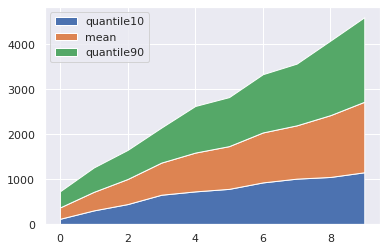

,Episode,Step,cum_step,Reward,Reward_cum,Eps,Avg_loss,Avg_loss_r,Avg_loss_N,Avg_loss_psi,Avg_loss_phi,carac,run
0,0,285,286,1.0,1.0,0.868516,0.002212,0.0,0.0,0.0,0.0,Q_latent_Lin,0
0,0,333,334,1.0,1.0,0.848157,0.002462,0.0,0.0,0.0,0.0,Q_latent_Lin,1
0,0,189,190,1.0,1.0,0.910729,0.001966,0.0,0.0,0.0,0.0,Q_latent_Lin,2
0,0,374,375,1.0,1.0,0.831149,0.001698,0.0,0.0,0.0,0.0,Q_latent_Lin,3
0,0,76,77,1.0,1.0,0.963086,0.000000,0.0,0.0,0.0,0.0,Q_latent_Lin,4


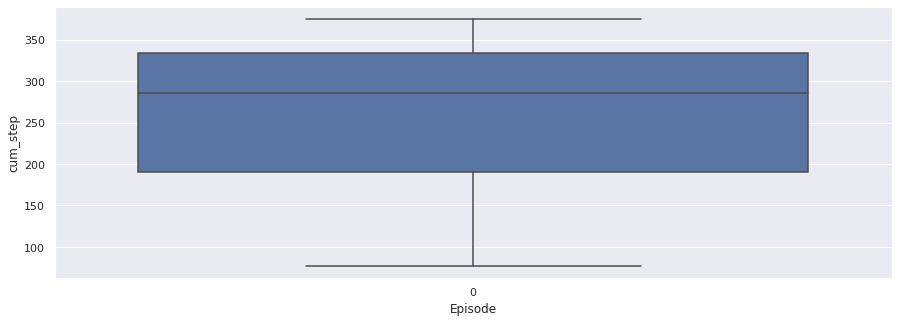

In [78]:
data_stat, stat_all = plot_stat(data, param_agent_simu , "cum_step")
box_plot(data, param_agent_simu, "cum_step")

### Deep Q-learning  --- original state

#### original environment

In [79]:
%%time

# choice of environement  : 
environment = env

# parameters of simulation : 

param_agent_simu = {}
param_agent_simu = param_agent.copy()

param_agent_simu["train_LSFM"] = False
param_agent_simu["double_model"] = True
param_agent_simu["train_on_Q_latent"] = False
param_agent_simu["model_Q_Lin"] = False
param_agent_simu["run"] =  5
param_agent_simu["policy"]["eps-greedy"]["exponantial"]["lambda"] =  0.0001

# load LSFM model : 
# agent = Agent(env, param_agent_simu)
# agent.model_LSFM = keras.models.load_model(folder_WORK+'/agent_LSFM_model')

# initialisation data
data = pd.DataFrame()
        
# launch experience of simulations
data, agent_Q = experience(environment, param_agent_simu)

# save model_Q
agent_Q.model.save(folder_WORK+'/agent_Q_model')









Agent_Q.model : initialization model_DQN
Episode: 000, step: 327, cumul_step: 0328, Reward: -58.0, Reward_cumul: -58.0, eps: 0.9682, avg loss: 0.0047
Episode: 001, step: 280, cumul_step: 0609, Reward: -46.0, Reward_cumul: -104.0, eps: 0.9416, avg loss: 0.0018
Episode: 002, step: 266, cumul_step: 0876, Reward: -34.0, Reward_cumul: -138.0, eps: 0.9171, avg loss: 0.0007
steps : 1000, episode : 3, eps : 0.9058786272390801
Episode: 003, step: 322, cumul_step: 1199, Reward: -67.0, Reward_cumul: -205.0, eps: 0.8882, avg loss: 0.0003
Episode: 004, step: 064, cumul_step: 1264, Reward: -9.0, Reward_cumul: -214.0, eps: 0.8825, avg loss: 0.0002
Episode: 005, step: 041, cumul_step: 1306, Reward: -8.0, Reward_cumul: -222.0, eps: 0.8789, avg loss: 0.0001
Episode: 006, step: 117, cumul_step: 1424, Reward: -27.0, Reward_cumul: -249.0, eps: 0.8687, avg loss: 0.0001
Episode: 007, step: 064, cumul_step: 1489, Reward: -5.0, Reward_cumul: -254.0, eps: 0.8631, avg loss: 0.0000
Episode: 008, step: 016, cumul_

### __SAVE__ DQN in './agent_Q_model'

In [80]:
# %%time

# param_agent_simu = param_agent.copy()

# param_agent_simu["policy"]["type"] = ["eps-greedy", "exponantial"]
# param_agent_simu["double_model"] = True
# param_agent_simu["train_LSFM"] = False
# param_agent_simu["train_on_Q_latent"] = False
# param_agent_simu["model_Q_Lin"] = False
# param_agent_simu["policy"]["eps-greedy"]["exponantial"]["lambda"]=0.0005
# param_agent_simu["run"] =  5

# param_agent_simu["reset_Q_model"] =  False

# data = pd.DataFrame()

# model_Q_copy = None
# environment = env

# for k in range(10) : 
#     if model_Q_copy == None: 
#         agent_Q = Agent_Q(environment, param_agent)
#         result_compile = simu(environment,param_agent_simu, agent, agent_Q)
#     else : 
#         agent_Q_simu = Agent_Q(environment, param_agent , modelclone = model_Q_copy)
#         result_compile = simu(environment,param_agent_simu, agent, agent_Q_simu)
        
#     data_train_df = pd.DataFrame(result_compile, columns=[ 
#     "Episode", 
#     "Step", 
#     "cum_step",
#     "Reward", 
#     "Reward_cum",
#     "Eps",  
#     "Avg_loss" ,  
#     "Avg_loss_r",  
#     "Avg_loss_N",  
#     "Avg_loss_psi"])

#     data_train_df["carac"] = carac_model(param_agent_simu) 
#     data_train_df["run"] = k
#     data = pd.concat([data, data_train_df])
    
    

# data_Deep_or_state  = data.copy()
    
# # fig, axs = plt.subplots(2, 3,figsize=(15, 10))

# # sns.lineplot(x="cum_step", y="Reward_cum", data=data_train_df, ax = axs[0,0] )
# # sns.lineplot(x="cum_step", y="Reward", data=data_train_df, ax = axs[0,1] )
# # sns.lineplot(x="cum_step", y="Avg_loss", data=data_train_df, ax = axs[0,2] )
# # sns.lineplot(x="cum_step", y="Eps", data=data_train_df, ax = axs[1,0] )

In [81]:

data_Deep_or_state  = data.copy()
data_Deep_or_state

,Episode,Step,cum_step,Reward,Reward_cum,Eps,Avg_loss,Avg_loss_r,Avg_loss_N,Avg_loss_psi,Avg_loss_phi,carac,run
0,0,327,328,-58.0,-58.0,0.968151,0.004668,0.0,0.0,0.0,0.0,Q_Deep,0
1,1,280,609,-46.0,-104.0,0.941601,0.001804,0.0,0.0,0.0,0.0,Q_Deep,0
2,2,266,876,-34.0,-138.0,0.917057,0.000731,0.0,0.0,0.0,0.0,Q_Deep,0
3,3,322,1199,-67.0,-205.0,0.888227,0.000337,0.0,0.0,0.0,0.0,Q_Deep,0
4,4,64,1264,-9.0,-214.0,0.882537,0.000241,0.0,0.0,0.0,0.0,Q_Deep,0
5,5,41,1306,-8.0,-222.0,0.878880,0.000090,0.0,0.0,0.0,0.0,Q_Deep,0
6,6,117,1424,-27.0,-249.0,0.868687,0.000083,0.0,0.0,0.0,0.0,Q_Deep,0
7,7,64,1489,-5.0,-254.0,0.863124,0.000020,0.0,0.0,0.0,0.0,Q_Deep,0
8,8,16,1506,-2.0,-256.0,0.861675,0.000006,0.0,0.0,0.0,0.0,Q_Deep,0
9,9,7,1514,-2.0,-258.0,0.860994,0.000005,0.0,0.0,0.0,0.0,Q_Deep,0


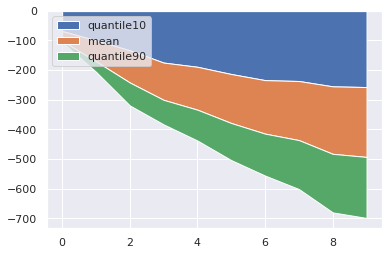

,Episode,Step,cum_step,Reward,Reward_cum,Eps,Avg_loss,Avg_loss_r,Avg_loss_N,Avg_loss_psi,Avg_loss_phi,carac,run
0,0,327,328,-58.0,-58.0,0.968151,0.004668,0.0,0.0,0.0,0.0,Q_Deep,0
0,0,146,147,-24.0,-24.0,0.985651,0.005063,0.0,0.0,0.0,0.0,Q_Deep,1
0,0,42,43,-4.0,-4.0,0.995851,0.000000,0.0,0.0,0.0,0.0,Q_Deep,2
0,0,12,13,-5.0,-5.0,0.998813,0.000000,0.0,0.0,0.0,0.0,Q_Deep,3
0,0,224,225,-75.0,-75.0,0.978071,0.007921,0.0,0.0,0.0,0.0,Q_Deep,4


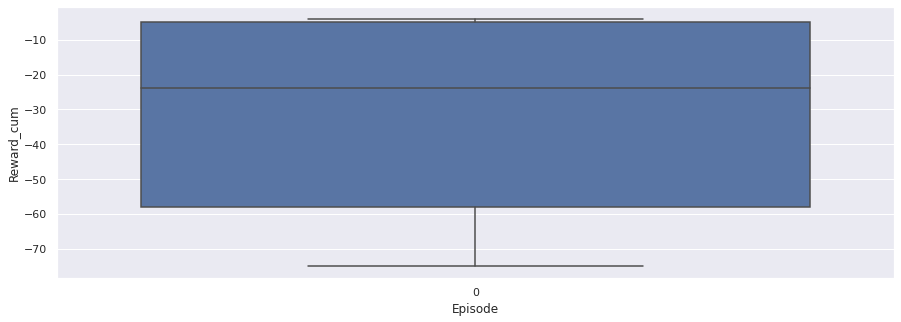

In [82]:
data_stat, stat_all = plot_stat(data, param_agent_simu , "Reward_cum")
box_plot(data, param_agent_simu, "Reward_cum")


#### change in environment rewards

In [83]:

%%time

# choice of environement  : 
environment = env_change_reward

# parameters of simulation : 

param_agent_simu = {}
param_agent_simu = param_agent.copy()

param_agent_simu["train_LSFM"] = False
param_agent_simu["double_model"] = True
param_agent_simu["train_on_Q_latent"] = False
param_agent_simu["model_Q_Lin"] = False
param_agent_simu["run"] =  2
param_agent_simu["policy"]["eps-greedy"]["exponantial"]["lambda"] =  0.0001


# load LSFM model : 
# agent = Agent(env, param_agent_simu)
# agent.model_LSFM = keras.models.load_model(folder_WORK+'/agent_LSFM_model')

# initialisation data
data = pd.DataFrame()
        
# launch experience of simulations
data, agent_Q = experience(environment, param_agent_simu, save_model = './agent_Q_model')

# save model_Q
# agent_Q.model.save(folder_WORK+"/agent_Q_model')





Agent_Q.model : load model 
layers name 0 latent
Episode: 000, step: 624, cumul_step: 0625, Reward: 1.0, Reward_cumul: 1.0, eps: 0.9401, avg loss: 0.0074
Episode: 001, step: 183, cumul_step: 0809, Reward: 1.0, Reward_cumul: 2.0, eps: 0.9232, avg loss: 0.0022
Episode: 002, step: 147, cumul_step: 0957, Reward: 1.0, Reward_cumul: 3.0, eps: 0.9097, avg loss: 0.0016
steps : 1000, episode : 3, eps : 0.9058786272390801
Episode: 003, step: 112, cumul_step: 1070, Reward: 1.0, Reward_cumul: 4.0, eps: 0.8996, avg loss: 0.0013
Episode: 004, step: 034, cumul_step: 1105, Reward: 1.0, Reward_cumul: 5.0, eps: 0.8965, avg loss: 0.0013
Episode: 005, step: 063, cumul_step: 1169, Reward: 1.0, Reward_cumul: 6.0, eps: 0.8909, avg loss: 0.0011
Episode: 006, step: 768, cumul_step: 1938, Reward: 1.0, Reward_cumul: 7.0, eps: 0.8257, avg loss: 0.0009
steps : 2000, episode : 7, eps : 0.8206245039446091
Episode: 007, step: 069, cumul_step: 2008, Reward: 1.0, Reward_cumul: 8.0, eps: 0.8200, avg loss: 0.0008
Episode

In [84]:
data_Deep_or_state_change  = data.copy()
data_Deep_or_state_change

,Episode,Step,cum_step,Reward,Reward_cum,Eps,Avg_loss,Avg_loss_r,Avg_loss_N,Avg_loss_psi,Avg_loss_phi,carac,run
0,0,624,625,1.0,1.0,0.940112,0.007437,0.0,0.0,0.0,0.0,Q_Deep,0
1,1,183,809,1.0,2.0,0.923154,0.002235,0.0,0.0,0.0,0.0,Q_Deep,0
2,2,147,957,1.0,3.0,0.909739,0.001559,0.0,0.0,0.0,0.0,Q_Deep,0
3,3,112,1070,1.0,4.0,0.899629,0.001330,0.0,0.0,0.0,0.0,Q_Deep,0
4,4,34,1105,1.0,5.0,0.896521,0.001274,0.0,0.0,0.0,0.0,Q_Deep,0
5,5,63,1169,1.0,6.0,0.890865,0.001139,0.0,0.0,0.0,0.0,Q_Deep,0
6,6,768,1938,1.0,7.0,0.825666,0.000866,0.0,0.0,0.0,0.0,Q_Deep,0
7,7,69,2008,1.0,8.0,0.819976,0.000761,0.0,0.0,0.0,0.0,Q_Deep,0
8,8,24,2033,1.0,9.0,0.817954,0.000793,0.0,0.0,0.0,0.0,Q_Deep,0
9,9,192,2226,1.0,10.0,0.802510,0.000780,0.0,0.0,0.0,0.0,Q_Deep,0


In [85]:
# %%time

# param_agent_simu = param_agent.copy()

# param_agent_simu["policy"]["type"] = ["eps-greedy", "exponantial"]
# param_agent_simu["double_model"] = True
# param_agent_simu["train_LSFM"] = False
# param_agent_simu["train_on_Q_latent"] = False
# param_agent_simu["model_Q_Lin"] = False
# param_agent_simu["policy"]["eps-greedy"]["exponantial"]["lambda"]=0.0005
# param_agent_simu["run"] =  5

# param_agent_simu["reset_Q_model"] =  False

# data = pd.DataFrame()

# model_Q_copy = agent_Q.model
# environment = env_change_reward

# for k in range(param_agent_simu["run"]) : 
#     if model_Q_copy == None: 
#         agent_Q = Agent_Q(environment, param_agent)
#         result_compile = simu(environment,param_agent_simu, agent, agent_Q)
#     else : 
#         agent_Q_simu = Agent_Q(environment, param_agent , modelclone = model_Q_copy)
#         result_compile = simu(environment,param_agent_simu, agent, agent_Q_simu)
        
    
#     data_train_df = pd.DataFrame(result_compile, columns=[ 
#     "Episode", 
#     "Step", 
#     "cum_step",
#     "Reward", 
#     "Reward_cum",
#     "Eps",  
#     "Avg_loss" ,  
#     "Avg_loss_r",  
#     "Avg_loss_N",  
#     "Avg_loss_psi"])

#     data_train_df["carac"] = carac_model(param_agent_simu) 
#     data_train_df["run"] = k
#     data = pd.concat([data, data_train_df])
    
    

# data_Deep_or_state_change  = data.copy()
    
# # fig, axs = plt.subplots(2, 3,figsize=(15, 10))

# # sns.lineplot(x="cum_step", y="Reward_cum", data=data_train_df, ax = axs[0,0] )
# # sns.lineplot(x="cum_step", y="Reward", data=data_train_df, ax = axs[0,1] )
# # sns.lineplot(x="cum_step", y="Avg_loss", data=data_train_df, ax = axs[0,2] )
# # sns.lineplot(x="cum_step", y="Eps", data=data_train_df, ax = axs[1,0] )

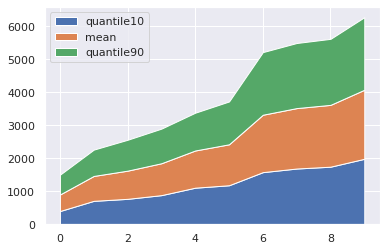

,Episode,Step,cum_step,Reward,Reward_cum,Eps,Avg_loss,Avg_loss_r,Avg_loss_N,Avg_loss_psi,Avg_loss_phi,carac,run
0,0,624,625,1.0,1.0,0.940112,0.007437,0.0,0.0,0.0,0.0,Q_Deep,0
0,0,376,377,1.0,1.0,0.963467,0.014401,0.0,0.0,0.0,0.0,Q_Deep,1


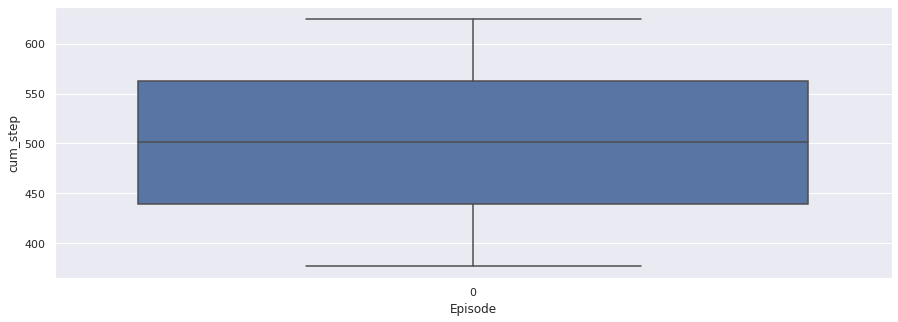

In [86]:
data_stat, stat_all = plot_stat(data, param_agent_simu , "cum_step")
box_plot(data, param_agent_simu, "cum_step")


# Load models

layers name 0 input
layers name 1 hidden_latent
layers name 2 latent
layers name 3 Fa
layers name 4 reshape_1
layers name 5 ra
tf.Tensor(
[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]], shape=(36, 30), dtype=bool)
Model: "model_LSFM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 36)]         0                                            
__________________________________________________________________________________________________
hidden_latent (Dense)           (None, 30)           1110        input[0][0]                      
______________________________________________________

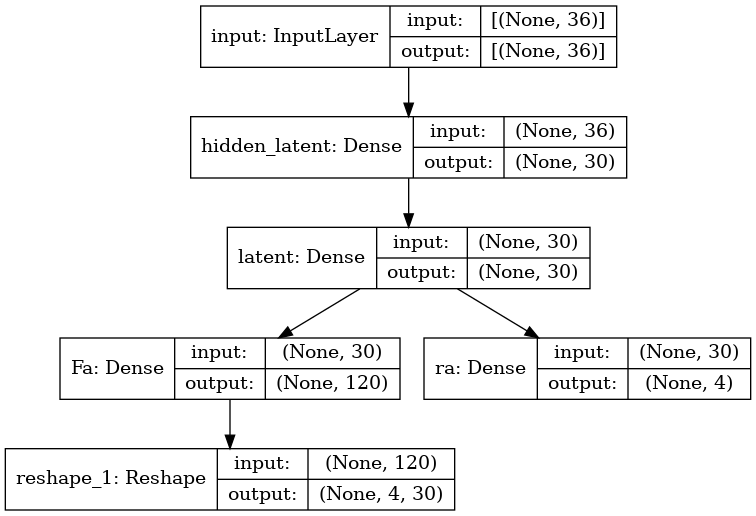

In [87]:

param_agent_simu = {}
param_agent_simu = param_agent.copy()

# load LSFM model : 
agent = Agent(env, param_agent_simu)

# load old model
old_folder = "LSFM_V2.5_dim1.2-hidden_ratio_12021-05-31_15h-20m-42s"


agent.model_LSFM = keras.models.load_model(old_folder+'/agent_LSFM_model')

model = agent.model_LSFM
for i in range(len(model.layers)):
    print("layers name",i,  model.layers[i].name)
    
aux_model_LSFM = tf.keras.Model(inputs=model.inputs,
           outputs=[model.layers[2].output])


state = env.reset()

n = env._state_dim  
# param_env["grid_size"]*param_env["grid_size"]

states = []
for i in range(n) :
    state = np.array(keras.utils.to_categorical(i,num_classes=n)).reshape(n)
    states.append(state)

    
states = np.array(states)
phi = agent.model_LSFM(states)["phi"]

print(aux_model_LSFM(states) == phi) 

agent.model_LSFM.summary()
keras.utils.plot_model(agent.model_LSFM, "my_first_model.png", show_shapes=True)


In [88]:
# choice of environement  : 
environment = env

# parameters of simulation : 

param_agent_simu = {}
param_agent_simu = param_agent.copy()

param_agent_simu["train_LSFM"] = False
param_agent_simu["double_model"] = True
param_agent_simu["train_on_Q_latent"] = False
param_agent_simu["model_Q_Lin"] = False
param_agent_simu["run"] =  5
# param_agent_simu["policy"]["eps-greedy"]["exponantial"]["lambda"] =  0.0002


# init learned Q model : 
agent_Q_simu = Agent_Q(environment, param = param_agent_simu, save_model = './agent_Q_model') 

model = agent_Q_simu.model
for i in range(len(model.layers)):
    print("layers name",i,  model.layers[i].name)
    
aux_model_Q = tf.keras.Model(inputs=model.inputs,
           outputs=[model.layers[0].output])

states = []
for i in range(n) :
    state = np.array(keras.utils.to_categorical(i,num_classes=n)).reshape(n)
    states.append(state)

    
states = np.array(states)
phi_Q = aux_model_Q(states)




Agent_Q.model : load model 
layers name 0 latent
layers name 0 latent
layers name 1 dense_40


# Clustering

## functions clustering

In [89]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn import manifold

def kmeans(XStd, n_clusters, perplexity=None) : 

    print(__doc__)

    best_random_state = 0

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(XStd) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=best_random_state)
    cluster_labels = clusterer.fit_predict(XStd)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(XStd, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(XStd, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    if perplexity == None : perplexity = 100
        
    embedding = manifold.TSNE(n_components=2, perplexity=perplexity, init='pca')
    # --- Visu 2d
    X_transformed = embedding.fit_transform(XStd)

    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_transformed[:, 0], X_transformed[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    #     centers = clusterer.cluster_centers_
    #     centers_transformed = embedding.fit_transform(centers)
    # Draw white circles at cluster centers
    #     ax2.scatter(centers_transformed[:, 0], centers_transformed[:, 1], marker='o',
    #                 c="white", alpha=1, s=200, edgecolor='k')

    #     for i, c in enumerate(centers_transformed):
    #         ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
    #                     s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    #     ax2.set_xlabel("Feature space for the 1st feature")
    #     ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()
    return cluster_labels



In [90]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def agglom(XStd, n_clusters, linkage = None, perplexity = None) : 
    print(__doc__)
    linkages = ["ward", "complete", "average", "single"]

    if linkage !=None : linkages = [linkage]

    for linkage in linkages:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])

        clusterer = AgglomerativeClustering(n_clusters= n_clusters   , linkage=linkage)
        cluster_labels = clusterer.fit_predict(XStd)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(XStd, cluster_labels)
        print("For linkages =", linkage,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(XStd, cluster_labels)

        y_lower = 10
        for i in range(len(np.unique(cluster_labels))):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) /  len(np.unique(cluster_labels)))
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed

        if perplexity == None : perplexity = 100
        embedding = manifold.TSNE(n_components=2, perplexity=perplexity, init='pca')
        # --- Visu 2d
        X_transformed = embedding.fit_transform(XStd)

        colors = cm.nipy_spectral(cluster_labels.astype(float) /  len(np.unique(cluster_labels)))
        ax2.scatter(X_transformed[:, 0], X_transformed[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')


        ax2.set_title("The visualization of the clustered data.")

    plt.show()
    return cluster_labels

## LSFM clustering

In [91]:

# param_agent_simu = {}
# param_agent_simu = param_agent.copy()

# # load LSFM model : 
# agent = Agent(env, param_agent_simu)
# agent.model_LSFM = keras.models.load_model(folder_WORK+'/agent_LSFM_model')

# model = agent.model_LSFM
# for i in range(len(model.layers)):
#     print("layers name",i,  model.layers[i].name)
    
# aux_model_LSFM = tf.keras.Model(inputs=model.inputs,
#            outputs=[model.layers[2].output])


In [92]:

# state = env.reset()

# n = env._state_dim  
# # param_env["grid_size"]*param_env["grid_size"]

# states = []
# for i in range(n) :
#     state = np.array(keras.utils.to_categorical(i,num_classes=n)).reshape(n)
#     states.append(state)

    
# states = np.array(states)
# phi = agent.model_LSFM(states)["phi"]

# aux_model_LSFM(states) == phi


In [93]:
# # choice of environement  : 
# environment = env

# # parameters of simulation : 

# param_agent_simu = {}
# param_agent_simu = param_agent.copy()

# param_agent_simu["train_LSFM"] = False
# param_agent_simu["double_model"] = True
# param_agent_simu["train_on_Q_latent"] = False
# param_agent_simu["model_Q_Lin"] = False
# param_agent_simu["run"] =  5
# param_agent_simu["policy"]["eps-greedy"]["exponantial"]["lambda"] =  0.0002


# agent_Q_simu = Agent_Q(environment, param = param_agent_simu, save_model = './agent_Q_model') 

# model = agent_Q_simu.model
# for i in range(len(model.layers)):
#     print("layers name",i,  model.layers[i].name)
    
# aux_model_Q = tf.keras.Model(inputs=model.inputs,
#            outputs=[model.layers[0].output])

In [94]:
# states = []
# for i in range(n) :
#     state = np.array(keras.utils.to_categorical(i,num_classes=n)).reshape(n)
#     states.append(state)

    
# states = np.array(states)
# phi_Q = aux_model_Q(states)


# aux_model_Q(states) == phi_Q


clustering in  30 clusters = latent space dimension
Automatically created module for IPython interactive environment
For linkages = ward The average silhouette_score is : 0.06972122


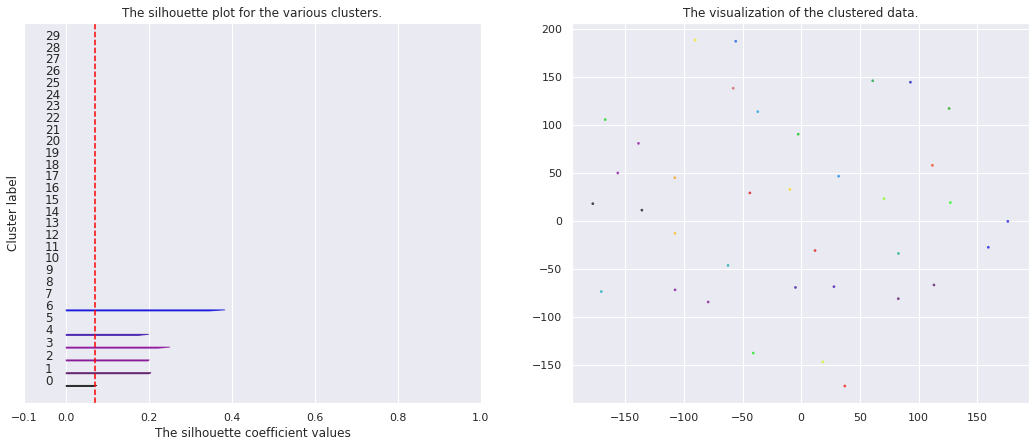

(array([[26, 20, 17, 23,  0,  0],
        [ 6,  6, 18, 25, 24,  3],
        [ 1,  1, 12, 19,  8,  3],
        [ 4,  4, 27, 15, 22, 16],
        [21,  7, 29,  9, 28, 13],
        [11, 10,  2,  2, 14,  5]]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]))

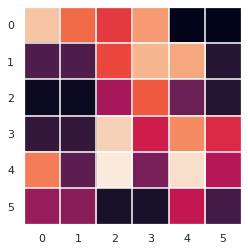

In [95]:
# "ward", "complete", "average", "single"
XStd = phi
ncluster = param_agent_simu["latent_space"]
print("clustering in ",ncluster, "clusters = latent space dimension" )
cluster_labels = agglom(XStd,ncluster, linkage = "ward", perplexity = 15)

cluster_labels_tab = cluster_labels.reshape(param_env["grid_size"],param_env["grid_size"])

state_dim = env._state_dim  



fig, ax = plt.subplots()
ax.imshow(cluster_labels_tab)

# Minor ticks
ax.set_xticks(np.arange(-.5, (state_dim)**0.5 - 1, 1), minor=True)
ax.set_yticks(np.arange(-.5, (state_dim)**0.5 - 1, 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='both', color='w', linestyle='-', linewidth=1.5)


cluster_labels_tab, np.unique(cluster_labels)


## DQN clustering

Automatically created module for IPython interactive environment
For linkages = ward The average silhouette_score is : 0.063048705


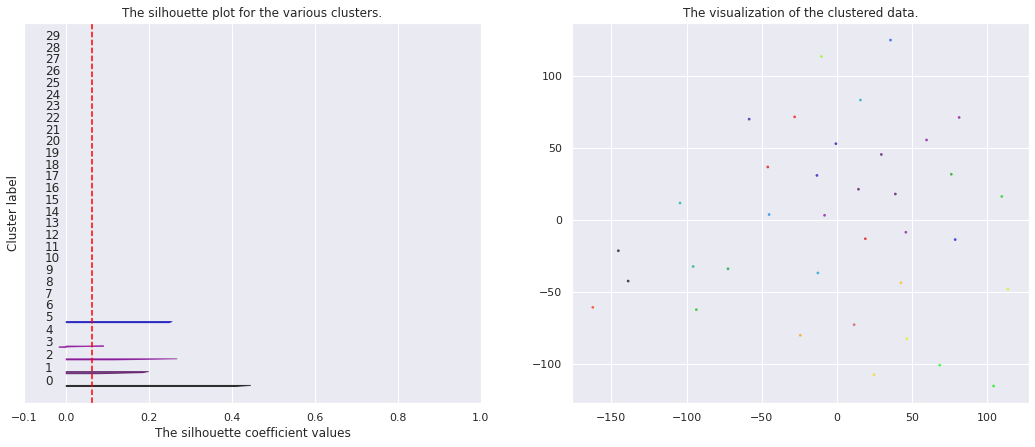

(array([[ 3, 23,  1, 19,  1, 27],
        [22, 21, 29, 24, 26, 28],
        [ 0, 25,  0, 18, 17,  3],
        [12, 15, 13, 11, 20,  5],
        [14,  9, 16,  6,  2,  1],
        [ 8, 10,  7,  4,  2,  5]]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]))

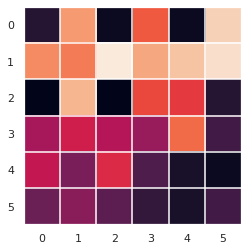

In [96]:
# "ward", "complete", "average", "single"
XStd = phi_Q
ncluster = param_agent_simu["latent_space"]

cluster_labels = agglom(XStd,ncluster, linkage = "ward", perplexity = 15)

cluster_labels_tab = cluster_labels.reshape(param_env["grid_size"],param_env["grid_size"])

state_dim = env._state_dim  



fig, ax = plt.subplots()
ax.imshow(cluster_labels_tab)

# Minor ticks
ax.set_xticks(np.arange(-.5, (state_dim)**0.5 - 1, 1), minor=True)
ax.set_yticks(np.arange(-.5, (state_dim)**0.5 - 1, 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='both', color='w', linestyle='-', linewidth=1.5)


cluster_labels_tab, np.unique(cluster_labels)

# results

## print date in files results

In [97]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
 
print("now =", now)

# dd/mm/YY H:M:S
dt_string = now.strftime("%Y-%m-%d_%Hh-%Mm-%Ss")
print("date and time =", dt_string)	

now = 2021-06-10 09:39:04.857422
date and time = 2021-06-10_09h-39m-04s


## compile results

### first environment : creation of latent space

In [98]:
data_concat = pd.concat([data_Q_lat_state,data_Deep_or_state])
data_concat   

,Episode,Step,cum_step,Reward,Reward_cum,Eps,Avg_loss,Avg_loss_r,Avg_loss_N,Avg_loss_psi,Avg_loss_phi,carac,run
0,0,385,386,-100.0,-100.0,0.962609,0.037280,0.0,0.0,0.0,0.0,Q_latent_Lin,0
1,1,190,577,-100.0,-200.0,0.944587,0.024916,0.0,0.0,0.0,0.0,Q_latent_Lin,0
2,2,8,586,-3.0,-203.0,0.943746,0.019688,0.0,0.0,0.0,0.0,Q_latent_Lin,0
3,3,86,673,-9.0,-212.0,0.935658,0.019233,0.0,0.0,0.0,0.0,Q_latent_Lin,0
4,4,451,1125,-69.0,-281.0,0.894750,0.009779,0.0,0.0,0.0,0.0,Q_latent_Lin,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,5,94,702,-27.0,-148.0,0.932978,0.000754,0.0,0.0,0.0,0.0,Q_Deep,4
6,6,20,723,-5.0,-153.0,0.931041,0.000790,0.0,0.0,0.0,0.0,Q_Deep,4
7,7,146,870,-11.0,-164.0,0.917601,0.000475,0.0,0.0,0.0,0.0,Q_Deep,4
8,8,89,960,-18.0,-182.0,0.909469,0.000495,0.0,0.0,0.0,0.0,Q_Deep,4


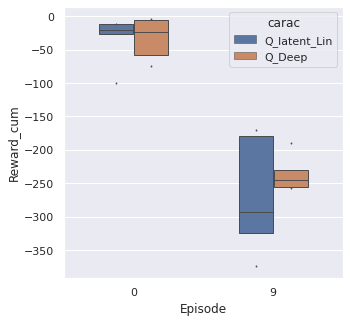

In [99]:
col = "Reward_cum"
hue = "carac"

data_Q_episode_par_10 = pd.DataFrame()

range_k = list(range(0,param_agent_simu["num_episodes"], 20))
range_k.append(param_agent_simu["num_episodes"]-1)


for k in range_k : 
    data_Q_episode_par_10 = pd.concat([data_Q_episode_par_10,
                                      data_concat.loc[lambda df: df['Episode'] == k]])
data_Q_episode_par_10

fig, axs = plt.subplots(1, 1,figsize=(5, 5))
sns.boxplot( x=data_Q_episode_par_10["Episode"], y=data_Q_episode_par_10[col] , 
            hue=data_Q_episode_par_10[hue], 
           saturation=0.7, width=0.5, dodge=True, fliersize=1, linewidth=1., whis=0)
# sns.scatterplot(data=data_Q_episode_par_10, x="Episode", y=col, hue=hue)
plt.savefig(folder_WORK+"/"+dt_string+"rewardCum_1rst_env.jpg")

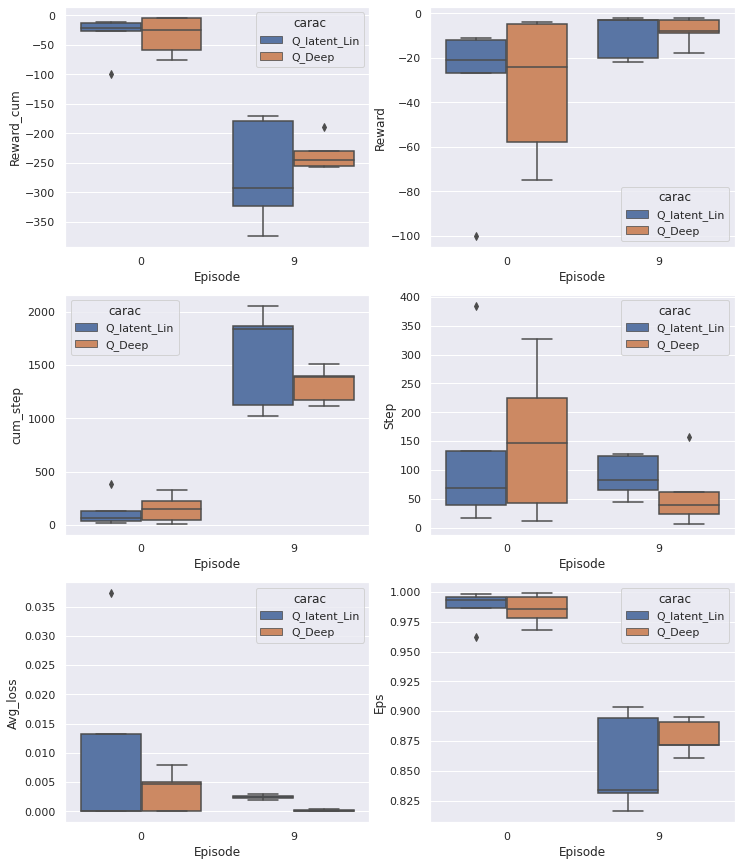

In [100]:
col = "Step"
hue = "carac"

data_Q_episode_par_10 = pd.DataFrame()

range_k = list(range(0,param_agent_simu["num_episodes"], 20))
range_k.append(param_agent_simu["num_episodes"]-1)


for k in range_k : 
    data_Q_episode_par_10 = pd.concat([data_Q_episode_par_10,
                                      data_concat.loc[lambda df: df['Episode'] == k]])
data_Q_episode_par_10

fig, axs = plt.subplots(3, 2,figsize=(12, 15))
# sns.boxplot( x=data_Q_episode_par_10["Episode"], y=data_Q_episode_par_10[col] , 
#             hue=data_Q_episode_par_10[hue], 
#            saturation=0.7, width=0.5, dodge=True, fliersize=1, linewidth=1., whis=0)
sns.boxplot(data=data_Q_episode_par_10, x="Episode", y="Reward_cum", hue=hue, ax = axs[0,0])
sns.boxplot(data=data_Q_episode_par_10, x="Episode", y="Reward", hue=hue, ax = axs[0,1])
sns.boxplot(data=data_Q_episode_par_10, x="Episode", y="cum_step", hue=hue, ax = axs[1,0])
sns.boxplot(data=data_Q_episode_par_10, x="Episode", y="Step", hue=hue, ax = axs[1,1])
sns.boxplot(data=data_Q_episode_par_10, x="Episode", y="Avg_loss", hue=hue, ax = axs[2,0])
sns.boxplot(data=data_Q_episode_par_10, x="Episode", y="Eps", hue=hue, ax = axs[2,1])
# sns.scatterplot(data=data_Q_episode_par_10, x="Episode", y="Reward_cum", hue=hue, ax = axs[0,1])
# axs.set(yscale="log")

plt.savefig(folder_WORK+"/"+dt_string+"results_1rst_env.jpg")

### second environment :  use of previous latent spaces

In [101]:
data_Q_lat_state_change["carac"] = "LSFNN"


In [102]:
data_concat = pd.concat([data_Q_lat_state_change,data_Deep_or_state_change ])
data_concat   

,Episode,Step,cum_step,Reward,Reward_cum,Eps,Avg_loss,Avg_loss_r,Avg_loss_N,Avg_loss_psi,Avg_loss_phi,carac,run
0,0,285,286,1.0,1.0,0.868516,0.002212,0.0,0.0,0.0,0.0,LSFNN,0
1,1,88,375,1.0,2.0,0.831149,0.001104,0.0,0.0,0.0,0.0,LSFNN,0
2,2,74,450,1.0,3.0,0.800926,0.000901,0.0,0.0,0.0,0.0,LSFNN,0
3,3,192,643,1.0,4.0,0.728169,0.000754,0.0,0.0,0.0,0.0,LSFNN,0
4,4,75,719,1.0,5.0,0.701391,0.000655,0.0,0.0,0.0,0.0,LSFNN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,5,162,1313,1.0,6.0,0.878272,0.002271,0.0,0.0,0.0,0.0,Q_Deep,1
6,6,227,1541,1.0,7.0,0.858699,0.001779,0.0,0.0,0.0,0.0,Q_Deep,1
7,7,113,1655,1.0,8.0,0.849079,0.001424,0.0,0.0,0.0,0.0,Q_Deep,1
8,8,58,1714,1.0,9.0,0.844143,0.001410,0.0,0.0,0.0,0.0,Q_Deep,1


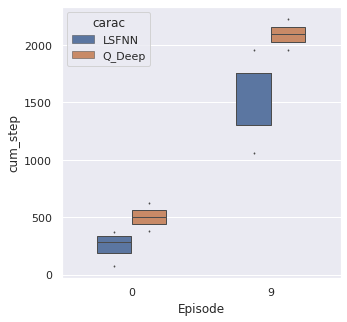

In [103]:
col = "cum_step"
hue = "carac"

data_Q_episode_par_10 = pd.DataFrame()

range_k = list(range(0,param_agent_simu["num_episodes"], 20))
range_k.append(param_agent_simu["num_episodes"]-1)


for k in range_k : 
    data_Q_episode_par_10 = pd.concat([data_Q_episode_par_10,
                                      data_concat.loc[lambda df: df['Episode'] == k]])
data_Q_episode_par_10

fig, axs = plt.subplots(1, 1,figsize=(5, 5))
sns.boxplot( x=data_Q_episode_par_10["Episode"], y=data_Q_episode_par_10[col] , 
            hue=data_Q_episode_par_10[hue], 
           saturation=0.7, width=0.5, dodge=True, fliersize=1, linewidth=1., whis=0)
# sns.scatterplot(data=data_Q_episode_par_10, x="Episode", y=col, hue=hue)
# axs.set(yscale="log")

plt.savefig(folder_WORK+"/"+dt_string+"results_2nd_env.jpg")

In [104]:
# fig, axs = plt.subplots(2, 3,figsize=(15, 10))

# sns.lineplot(x="cum_step", y="Reward_cum", data=data_train_df, ax = axs[0,0] )
# sns.lineplot(x="cum_step", y="Reward", data=data_train_df, ax = axs[0,1] )
# sns.lineplot(x="cum_step", y="Avg_loss", data=data_train_df, ax = axs[0,2] )
# sns.lineplot(x="cum_step", y="Eps", data=data_train_df, ax = axs[1,0] )

## See results

In [105]:
# data_Q_or_state.loc[lambda df: df['Episode'] == 0]

* Filter_done must be activate even for the learning of the LSFM model

In [106]:
# param_agent_simu = {}
# param_agent_simu = param_agent.copy()
# param_agent_simu["train_LSFM"] = False
# param_agent_simu["train_on_Q_latent"] = False
# param_agent_simu["model_Q_Lin"] = False
# param_agent_simu["num_episodes"] = 1
# param_agent_simu["policy"]["type"] = ["eps-greedy", "constant"]
# param_agent_simu["policy"]["eps-greedy"]["constant"]["eps"]=0.00
# param_agent_simu["train"]=False
# param_agent_simu["render"]=True
# simu(env,param_agent_simu,agent)


In [107]:

# data_see_df = pd.DataFrame(result_compile, columns=[ "Episode", "Step", "cum_step", "Reward", "Reward_cum", "Avg_loss", "Eps"])


# data_see_df.to_csv('data_see_df.csv', sep='\t', encoding='utf-8')


# import matplotlib.pyplot as plt

# fig, axs = plt.subplots(2, 3,figsize=(15, 10))


# plt.figure(figsize=(5, 5))
# sns.lineplot(x="cum_step", y="Reward_cum", data=data_see_df, ax = axs[0,0] )
# sns.lineplot(x="cum_step", y="Reward", data=data_see_df, ax = axs[0,1] )
# sns.lineplot(x="cum_step", y="Avg_loss", data=data_see_df, ax = axs[0,2] )
# sns.lineplot(x="cum_step", y="Eps", data=data_see_df, ax = axs[1,0] )

In [108]:
# env.close()

# SF Matrices

## get F_bar matrice

Model: "model_LSFM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 36)]         0                                            
__________________________________________________________________________________________________
hidden_latent (Dense)           (None, 30)           1110        input[0][0]                      
__________________________________________________________________________________________________
latent (Dense)                  (None, 30)           930         hidden_latent[0][0]              
__________________________________________________________________________________________________
Fa (Dense)                      (None, 120)          3600        latent[0][0]                     
_________________________________________________________________________________________

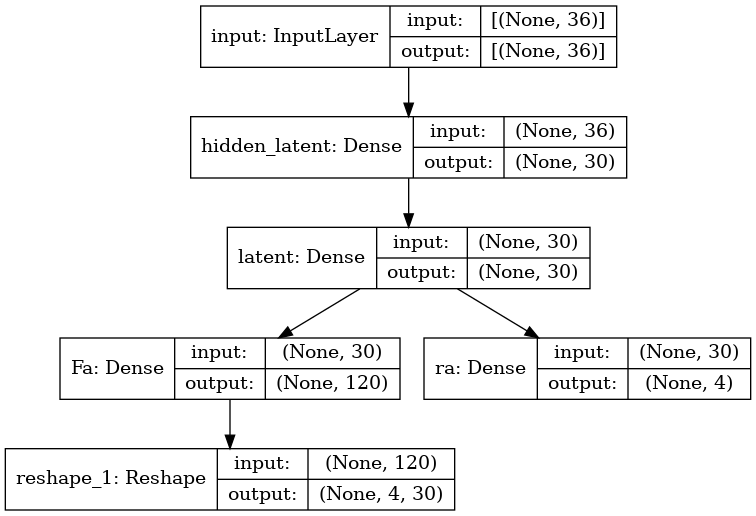

In [109]:
agent.model_LSFM.summary()
keras.utils.plot_model(agent.model_LSFM, "my_first_model.png", show_shapes=True)

In [110]:
for idl, layer in enumerate(agent.model_LSFM.layers):
    name_a = "Fa"
    if layer.name == name_a :         
        Fa = layer.weights[0]

print("weights Fa : ",Fa.shape)
Fa_reshape = tf.reshape(Fa, (Fa.shape[0],4,Fa.shape[0]))
print("Fa : ",Fa_reshape.shape)
F_bar = tf.math.reduce_mean( Fa_reshape, axis=1 )
print("F_bar : ",F_bar.shape)


weights Fa :  (30, 120)
Fa :  (30, 4, 30)
F_bar :  (30, 30)


In [111]:
def plot_matrice(M) : 

    fig, ax = plt.subplots()
    ax.imshow(M)
    dim = M.shape[0]
    # Minor ticks
    ax.set_xticks(np.arange(-.5, dim - 1, 1), minor=True)
    ax.set_yticks(np.arange(-.5, dim - 1, 1), minor=True)

    # Gridlines based on minor ticks
    ax.grid(which='both', color='w', linestyle='-', linewidth=1.5)

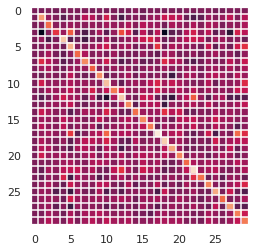

In [112]:
plot_matrice(F_bar)

## get transition function matrice

In [113]:
param_agent = {
    "gamma": 0.90,
    "optimizer_LSFM": keras.optimizers.Adam(),
    "optimizer_Q": keras.optimizers.Adam(),
    "alpha_r" : 1.,
    "alpha_N" : 0.1,
    "alpha_psi" : 0.1,
    "policy": {
        "type": ["random"]
    },
    "memory" : 500000,
    "latent_space": latent_dimension,
    "hidden_dim_ratio": hidden_ratio,
    "num_episodes" : 50,
    "batch_size" : 32,
    "RANDOM_REWARD_STD" : -1.0, 
    "double_model" : True,
    "tau": 0.08,
    "filter_done" : True,
    "train_LSFM" : False,
    "train_on_Q_latent": False,
    "model_Q_Lin": False,
    "train" : False,
    "render": False,
    "run": 20,
    "avg_loss_phisp1" : True,
}

# choice of environement  : 
environment = env

# parameters of simulation : 
param_agent_simu = {}
param_agent_simu = param_agent.copy()

# param_agent_simu["render"] =  False

# launch experience of simulations
data, agent_Q = experience(environment, param_agent_simu, agent = agent)




Agent_Q.model : initialization model_DQN
Episode: 000, step: 127, cumul_step: 0128, Reward: -27.0, Reward_cumul: -27.0, eps: 1.0000, avg loss: 0.0000
Episode: 001, step: 053, cumul_step: 0182, Reward: -4.0, Reward_cumul: -31.0, eps: 1.0000, avg loss: 0.0000
Episode: 002, step: 144, cumul_step: 0327, Reward: -46.0, Reward_cumul: -77.0, eps: 1.0000, avg loss: 0.0000
Episode: 003, step: 126, cumul_step: 0454, Reward: -50.0, Reward_cumul: -127.0, eps: 1.0000, avg loss: 0.0000
Episode: 004, step: 096, cumul_step: 0551, Reward: -39.0, Reward_cumul: -166.0, eps: 1.0000, avg loss: 0.0000
Episode: 005, step: 081, cumul_step: 0633, Reward: -9.0, Reward_cumul: -175.0, eps: 1.0000, avg loss: 0.0000
Episode: 006, step: 236, cumul_step: 0870, Reward: -40.0, Reward_cumul: -215.0, eps: 1.0000, avg loss: 0.0000
steps : 1000, episode : 7, eps : 1.0
Episode: 007, step: 511, cumul_step: 1382, Reward: -105.0, Reward_cumul: -320.0, eps: 1.0000, avg loss: 0.0000
Episode: 008, step: 153, cumul_step: 1536, Rew

Episode: 021, step: 079, cumul_step: 3403, Reward: -19.0, Reward_cumul: -666.0, eps: 1.0000, avg loss: 0.0000
Episode: 022, step: 164, cumul_step: 3568, Reward: -38.0, Reward_cumul: -704.0, eps: 1.0000, avg loss: 0.0000
steps : 4000, episode : 23, eps : 1.0
steps : 5000, episode : 23, eps : 1.0
Episode: 023, step: 1637, cumul_step: 5206, Reward: -303.0, Reward_cumul: -1007.0, eps: 1.0000, avg loss: 0.0000
Episode: 024, step: 221, cumul_step: 5428, Reward: -43.0, Reward_cumul: -1050.0, eps: 1.0000, avg loss: 0.0000
Episode: 025, step: 093, cumul_step: 5522, Reward: -12.0, Reward_cumul: -1062.0, eps: 1.0000, avg loss: 0.0000
Episode: 026, step: 106, cumul_step: 5629, Reward: -22.0, Reward_cumul: -1084.0, eps: 1.0000, avg loss: 0.0000
Episode: 027, step: 009, cumul_step: 5639, Reward: -2.0, Reward_cumul: -1086.0, eps: 1.0000, avg loss: 0.0000
Episode: 028, step: 015, cumul_step: 5655, Reward: -4.0, Reward_cumul: -1090.0, eps: 1.0000, avg loss: 0.0000
steps : 6000, episode : 29, eps : 1.0


Episode: 043, step: 682, cumul_step: 6718, Reward: -137.0, Reward_cumul: -1408.0, eps: 1.0000, avg loss: 0.0000
steps : 7000, episode : 44, eps : 1.0
Episode: 044, step: 283, cumul_step: 7002, Reward: -57.0, Reward_cumul: -1465.0, eps: 1.0000, avg loss: 0.0000
Episode: 045, step: 026, cumul_step: 7029, Reward: -9.0, Reward_cumul: -1474.0, eps: 1.0000, avg loss: 0.0000
Episode: 046, step: 152, cumul_step: 7182, Reward: -24.0, Reward_cumul: -1498.0, eps: 1.0000, avg loss: 0.0000
Episode: 047, step: 039, cumul_step: 7222, Reward: -5.0, Reward_cumul: -1503.0, eps: 1.0000, avg loss: 0.0000
Episode: 048, step: 061, cumul_step: 7284, Reward: -18.0, Reward_cumul: -1521.0, eps: 1.0000, avg loss: 0.0000
Episode: 049, step: 191, cumul_step: 7476, Reward: -63.0, Reward_cumul: -1584.0, eps: 1.0000, avg loss: 0.0000
Agent_Q.model : initialization model_DQN
Episode: 000, step: 076, cumul_step: 0077, Reward: -18.0, Reward_cumul: -18.0, eps: 1.0000, avg loss: 0.0000
Episode: 001, step: 129, cumul_step:

Episode: 014, step: 114, cumul_step: 2322, Reward: -24.0, Reward_cumul: -501.0, eps: 1.0000, avg loss: 0.0000
Episode: 015, step: 020, cumul_step: 2343, Reward: -8.0, Reward_cumul: -509.0, eps: 1.0000, avg loss: 0.0000
Episode: 016, step: 372, cumul_step: 2716, Reward: -115.0, Reward_cumul: -624.0, eps: 1.0000, avg loss: 0.0000
Episode: 017, step: 073, cumul_step: 2790, Reward: -6.0, Reward_cumul: -630.0, eps: 1.0000, avg loss: 0.0000
Episode: 018, step: 026, cumul_step: 2817, Reward: -2.0, Reward_cumul: -632.0, eps: 1.0000, avg loss: 0.0000
Episode: 019, step: 026, cumul_step: 2844, Reward: -9.0, Reward_cumul: -641.0, eps: 1.0000, avg loss: 0.0000
Episode: 020, step: 035, cumul_step: 2880, Reward: -4.0, Reward_cumul: -645.0, eps: 1.0000, avg loss: 0.0000
Episode: 021, step: 068, cumul_step: 2949, Reward: -25.0, Reward_cumul: -670.0, eps: 1.0000, avg loss: 0.0000
steps : 3000, episode : 22, eps : 1.0
Episode: 022, step: 223, cumul_step: 3173, Reward: -35.0, Reward_cumul: -705.0, eps: 1

Episode: 035, step: 189, cumul_step: 5686, Reward: -38.0, Reward_cumul: -1168.0, eps: 1.0000, avg loss: 0.0000
Episode: 036, step: 123, cumul_step: 5810, Reward: -15.0, Reward_cumul: -1183.0, eps: 1.0000, avg loss: 0.0000
Episode: 037, step: 046, cumul_step: 5857, Reward: -12.0, Reward_cumul: -1195.0, eps: 1.0000, avg loss: 0.0000
Episode: 038, step: 116, cumul_step: 5974, Reward: -34.0, Reward_cumul: -1229.0, eps: 1.0000, avg loss: 0.0000
steps : 6000, episode : 39, eps : 1.0
Episode: 039, step: 187, cumul_step: 6162, Reward: -49.0, Reward_cumul: -1278.0, eps: 1.0000, avg loss: 0.0000
Episode: 040, step: 210, cumul_step: 6373, Reward: -22.0, Reward_cumul: -1300.0, eps: 1.0000, avg loss: 0.0000
Episode: 041, step: 201, cumul_step: 6575, Reward: -44.0, Reward_cumul: -1344.0, eps: 1.0000, avg loss: 0.0000
Episode: 042, step: 139, cumul_step: 6715, Reward: -59.0, Reward_cumul: -1403.0, eps: 1.0000, avg loss: 0.0000
Episode: 043, step: 056, cumul_step: 6772, Reward: -29.0, Reward_cumul: -1

Episode: 007, step: 025, cumul_step: 1033, Reward: -6.0, Reward_cumul: -233.0, eps: 1.0000, avg loss: 0.0000
Episode: 008, step: 012, cumul_step: 1046, Reward: -5.0, Reward_cumul: -238.0, eps: 1.0000, avg loss: 0.0000
Episode: 009, step: 025, cumul_step: 1072, Reward: -4.0, Reward_cumul: -242.0, eps: 1.0000, avg loss: 0.0000
Episode: 010, step: 023, cumul_step: 1096, Reward: -4.0, Reward_cumul: -246.0, eps: 1.0000, avg loss: 0.0000
Episode: 011, step: 220, cumul_step: 1317, Reward: -47.0, Reward_cumul: -293.0, eps: 1.0000, avg loss: 0.0000
Episode: 012, step: 017, cumul_step: 1335, Reward: -2.0, Reward_cumul: -295.0, eps: 1.0000, avg loss: 0.0000
Episode: 013, step: 151, cumul_step: 1487, Reward: -18.0, Reward_cumul: -313.0, eps: 1.0000, avg loss: 0.0000
Episode: 014, step: 027, cumul_step: 1515, Reward: -8.0, Reward_cumul: -321.0, eps: 1.0000, avg loss: 0.0000
Episode: 015, step: 306, cumul_step: 1822, Reward: -86.0, Reward_cumul: -407.0, eps: 1.0000, avg loss: 0.0000
steps : 2000, ep

Episode: 032, step: 237, cumul_step: 4667, Reward: -20.0, Reward_cumul: -1117.0, eps: 1.0000, avg loss: 0.0000
Episode: 033, step: 030, cumul_step: 4698, Reward: -4.0, Reward_cumul: -1121.0, eps: 1.0000, avg loss: 0.0000
Episode: 034, step: 130, cumul_step: 4829, Reward: -22.0, Reward_cumul: -1143.0, eps: 1.0000, avg loss: 0.0000
Episode: 035, step: 022, cumul_step: 4852, Reward: -12.0, Reward_cumul: -1155.0, eps: 1.0000, avg loss: 0.0000
steps : 5000, episode : 36, eps : 1.0
Episode: 036, step: 427, cumul_step: 5280, Reward: -136.0, Reward_cumul: -1291.0, eps: 1.0000, avg loss: 0.0000
Episode: 037, step: 087, cumul_step: 5368, Reward: -34.0, Reward_cumul: -1325.0, eps: 1.0000, avg loss: 0.0000
Episode: 038, step: 065, cumul_step: 5434, Reward: -12.0, Reward_cumul: -1337.0, eps: 1.0000, avg loss: 0.0000
Episode: 039, step: 011, cumul_step: 5446, Reward: -1.0, Reward_cumul: -1338.0, eps: 1.0000, avg loss: 0.0000
Episode: 040, step: 036, cumul_step: 5483, Reward: -7.0, Reward_cumul: -134

Episode: 003, step: 247, cumul_step: 0506, Reward: -33.0, Reward_cumul: -64.0, eps: 1.0000, avg loss: 0.0000
Episode: 004, step: 045, cumul_step: 0552, Reward: -9.0, Reward_cumul: -73.0, eps: 1.0000, avg loss: 0.0000
steps : 1000, episode : 5, eps : 1.0
Episode: 005, step: 848, cumul_step: 1401, Reward: -171.0, Reward_cumul: -244.0, eps: 1.0000, avg loss: 0.0000
Episode: 006, step: 183, cumul_step: 1585, Reward: -43.0, Reward_cumul: -287.0, eps: 1.0000, avg loss: 0.0000
Episode: 007, step: 024, cumul_step: 1610, Reward: -9.0, Reward_cumul: -296.0, eps: 1.0000, avg loss: 0.0000
Episode: 008, step: 039, cumul_step: 1650, Reward: -16.0, Reward_cumul: -312.0, eps: 1.0000, avg loss: 0.0000
Episode: 009, step: 074, cumul_step: 1725, Reward: -2.0, Reward_cumul: -314.0, eps: 1.0000, avg loss: 0.0000
Episode: 010, step: 076, cumul_step: 1802, Reward: -14.0, Reward_cumul: -328.0, eps: 1.0000, avg loss: 0.0000
Episode: 011, step: 184, cumul_step: 1987, Reward: -64.0, Reward_cumul: -392.0, eps: 1.

Episode: 025, step: 281, cumul_step: 3419, Reward: -51.0, Reward_cumul: -729.0, eps: 1.0000, avg loss: 0.0000
Episode: 026, step: 255, cumul_step: 3675, Reward: -69.0, Reward_cumul: -798.0, eps: 1.0000, avg loss: 0.0000
Episode: 027, step: 105, cumul_step: 3781, Reward: -18.0, Reward_cumul: -816.0, eps: 1.0000, avg loss: 0.0000
Episode: 028, step: 017, cumul_step: 3799, Reward: -5.0, Reward_cumul: -821.0, eps: 1.0000, avg loss: 0.0000
Episode: 029, step: 070, cumul_step: 3870, Reward: -23.0, Reward_cumul: -844.0, eps: 1.0000, avg loss: 0.0000
steps : 4000, episode : 30, eps : 1.0
Episode: 030, step: 144, cumul_step: 4015, Reward: -22.0, Reward_cumul: -866.0, eps: 1.0000, avg loss: 0.0000
Episode: 031, step: 269, cumul_step: 4285, Reward: -41.0, Reward_cumul: -907.0, eps: 1.0000, avg loss: 0.0000
Episode: 032, step: 196, cumul_step: 4482, Reward: -64.0, Reward_cumul: -971.0, eps: 1.0000, avg loss: 0.0000
Episode: 033, step: 048, cumul_step: 4531, Reward: -6.0, Reward_cumul: -977.0, eps:

Episode: 048, step: 146, cumul_step: 7687, Reward: -19.0, Reward_cumul: -1552.0, eps: 1.0000, avg loss: 0.0000
Episode: 049, step: 165, cumul_step: 7853, Reward: -10.0, Reward_cumul: -1562.0, eps: 1.0000, avg loss: 0.0000
Agent_Q.model : initialization model_DQN
Episode: 000, step: 012, cumul_step: 0013, Reward: -2.0, Reward_cumul: -2.0, eps: 1.0000, avg loss: 0.0000
Episode: 001, step: 163, cumul_step: 0177, Reward: -25.0, Reward_cumul: -27.0, eps: 1.0000, avg loss: 0.0000
Episode: 002, step: 027, cumul_step: 0205, Reward: -6.0, Reward_cumul: -33.0, eps: 1.0000, avg loss: 0.0000
Episode: 003, step: 337, cumul_step: 0543, Reward: -58.0, Reward_cumul: -91.0, eps: 1.0000, avg loss: 0.0000
Episode: 004, step: 388, cumul_step: 0932, Reward: -101.0, Reward_cumul: -192.0, eps: 1.0000, avg loss: 0.0000
steps : 1000, episode : 5, eps : 1.0
Episode: 005, step: 101, cumul_step: 1034, Reward: -8.0, Reward_cumul: -200.0, eps: 1.0000, avg loss: 0.0000
Episode: 006, step: 068, cumul_step: 1103, Rewa

Episode: 021, step: 069, cumul_step: 2733, Reward: -32.0, Reward_cumul: -678.0, eps: 1.0000, avg loss: 0.0000
Episode: 022, step: 168, cumul_step: 2902, Reward: -33.0, Reward_cumul: -711.0, eps: 1.0000, avg loss: 0.0000
Episode: 023, step: 036, cumul_step: 2939, Reward: -13.0, Reward_cumul: -724.0, eps: 1.0000, avg loss: 0.0000
Episode: 024, step: 029, cumul_step: 2969, Reward: -5.0, Reward_cumul: -729.0, eps: 1.0000, avg loss: 0.0000
steps : 3000, episode : 25, eps : 1.0
Episode: 025, step: 042, cumul_step: 3012, Reward: -3.0, Reward_cumul: -732.0, eps: 1.0000, avg loss: 0.0000
Episode: 026, step: 068, cumul_step: 3081, Reward: -39.0, Reward_cumul: -771.0, eps: 1.0000, avg loss: 0.0000
Episode: 027, step: 087, cumul_step: 3169, Reward: -18.0, Reward_cumul: -789.0, eps: 1.0000, avg loss: 0.0000
Episode: 028, step: 052, cumul_step: 3222, Reward: -23.0, Reward_cumul: -812.0, eps: 1.0000, avg loss: 0.0000
Episode: 029, step: 178, cumul_step: 3401, Reward: -53.0, Reward_cumul: -865.0, eps:

Episode: 043, step: 170, cumul_step: 6746, Reward: -40.0, Reward_cumul: -1418.0, eps: 1.0000, avg loss: 0.0000
Episode: 044, step: 027, cumul_step: 6774, Reward: -8.0, Reward_cumul: -1426.0, eps: 1.0000, avg loss: 0.0000
Episode: 045, step: 036, cumul_step: 6811, Reward: -12.0, Reward_cumul: -1438.0, eps: 1.0000, avg loss: 0.0000
Episode: 046, step: 176, cumul_step: 6988, Reward: -23.0, Reward_cumul: -1461.0, eps: 1.0000, avg loss: 0.0000
steps : 7000, episode : 47, eps : 1.0
Episode: 047, step: 023, cumul_step: 7012, Reward: -6.0, Reward_cumul: -1467.0, eps: 1.0000, avg loss: 0.0000
Episode: 048, step: 075, cumul_step: 7088, Reward: -23.0, Reward_cumul: -1490.0, eps: 1.0000, avg loss: 0.0000
Episode: 049, step: 616, cumul_step: 7705, Reward: -123.0, Reward_cumul: -1613.0, eps: 1.0000, avg loss: 0.0000
Agent_Q.model : initialization model_DQN
Episode: 000, step: 140, cumul_step: 0141, Reward: -20.0, Reward_cumul: -20.0, eps: 1.0000, avg loss: 0.0000
Episode: 001, step: 051, cumul_step:

Episode: 015, step: 055, cumul_step: 3174, Reward: 0.0, Reward_cumul: -801.0, eps: 1.0000, avg loss: 0.0000
Episode: 016, step: 270, cumul_step: 3445, Reward: -96.0, Reward_cumul: -897.0, eps: 1.0000, avg loss: 0.0000
Episode: 017, step: 263, cumul_step: 3709, Reward: -36.0, Reward_cumul: -933.0, eps: 1.0000, avg loss: 0.0000
Episode: 018, step: 196, cumul_step: 3906, Reward: -52.0, Reward_cumul: -985.0, eps: 1.0000, avg loss: 0.0000
steps : 4000, episode : 19, eps : 1.0
Episode: 019, step: 272, cumul_step: 4179, Reward: -79.0, Reward_cumul: -1064.0, eps: 1.0000, avg loss: 0.0000
Episode: 020, step: 238, cumul_step: 4418, Reward: -63.0, Reward_cumul: -1127.0, eps: 1.0000, avg loss: 0.0000
Episode: 021, step: 106, cumul_step: 4525, Reward: -46.0, Reward_cumul: -1173.0, eps: 1.0000, avg loss: 0.0000
Episode: 022, step: 351, cumul_step: 4877, Reward: -69.0, Reward_cumul: -1242.0, eps: 1.0000, avg loss: 0.0000
Episode: 023, step: 109, cumul_step: 4987, Reward: -18.0, Reward_cumul: -1260.0,

Episode: 036, step: 083, cumul_step: 5895, Reward: -19.0, Reward_cumul: -1177.0, eps: 1.0000, avg loss: 0.0000
steps : 6000, episode : 37, eps : 1.0
Episode: 037, step: 328, cumul_step: 6224, Reward: -42.0, Reward_cumul: -1219.0, eps: 1.0000, avg loss: 0.0000
Episode: 038, step: 144, cumul_step: 6369, Reward: -49.0, Reward_cumul: -1268.0, eps: 1.0000, avg loss: 0.0000
Episode: 039, step: 221, cumul_step: 6591, Reward: -35.0, Reward_cumul: -1303.0, eps: 1.0000, avg loss: 0.0000
Episode: 040, step: 043, cumul_step: 6635, Reward: -20.0, Reward_cumul: -1323.0, eps: 1.0000, avg loss: 0.0000
Episode: 041, step: 118, cumul_step: 6754, Reward: -36.0, Reward_cumul: -1359.0, eps: 1.0000, avg loss: 0.0000
Episode: 042, step: 128, cumul_step: 6883, Reward: -17.0, Reward_cumul: -1376.0, eps: 1.0000, avg loss: 0.0000
steps : 7000, episode : 43, eps : 1.0
Episode: 043, step: 122, cumul_step: 7006, Reward: -38.0, Reward_cumul: -1414.0, eps: 1.0000, avg loss: 0.0000
Episode: 044, step: 400, cumul_step:

In [114]:
# print("data",data["Avg_loss_phi"].mean())

data
# fig, axs = plt.subplots(2, 3,figsize=(15, 10))
# sns.lineplot(x="Step", y="Avg_loss_phi", data=data, ax = axs[0,0])
# sns.lineplot(x="cum_step", y="Avg_loss_phi", data=data, ax = axs[0,1] )
# sns.lineplot(x="cum_step", y="Avg_loss_r", data=data, ax = axs[1,0] )
# # sns.lineplot(x="cum_step", y="Avg_loss", data=data_see_df, ax = axs[0,2] )
# # sns.lineplot(x="cum_step", y="Eps", data=data_see_df, ax = axs[1,0] )
# plt.show()

,Episode,Step,cum_step,Reward,Reward_cum,Eps,Avg_loss,Avg_loss_r,Avg_loss_N,Avg_loss_psi,Avg_loss_phi,carac,run
0,0,127,128,-27.0,-27.0,1.0,0.0,0.0,0.0,0.0,NaN,Q_Deep,0
1,1,53,182,-4.0,-31.0,1.0,0.0,0.0,0.0,0.0,NaN,Q_Deep,0
2,2,144,327,-46.0,-77.0,1.0,0.0,0.0,0.0,0.0,NaN,Q_Deep,0
3,3,126,454,-50.0,-127.0,1.0,0.0,0.0,0.0,0.0,NaN,Q_Deep,0
4,4,96,551,-39.0,-166.0,1.0,0.0,0.0,0.0,0.0,NaN,Q_Deep,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,45,59,7730,-30.0,-1669.0,1.0,0.0,0.0,0.0,0.0,NaN,Q_Deep,19
46,46,75,7806,-23.0,-1692.0,1.0,0.0,0.0,0.0,0.0,NaN,Q_Deep,19
47,47,286,8093,-47.0,-1739.0,1.0,0.0,0.0,0.0,0.0,NaN,Q_Deep,19
48,48,120,8214,-23.0,-1762.0,1.0,0.0,0.0,0.0,0.0,NaN,Q_Deep,19


/home/ious/miniconda3/envs/gym/lib/python3.8/site-packages/numpy/lib/function_base.py:3942: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
/home/ious/miniconda3/envs/gym/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1211: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/home/ious/miniconda3/envs/gym/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1218: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/home/ious/miniconda3/envs/gym/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1227: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],
/home/ious/miniconda3/envs/gym/lib/python3.8/site-packages/numpy/lib/function_base.py:3942: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
/home/ious/miniconda3/envs/gym/lib/python3.8/site-packages/matplot

<AxesSubplot:xlabel='Step', ylabel='Avg_loss_phi'>

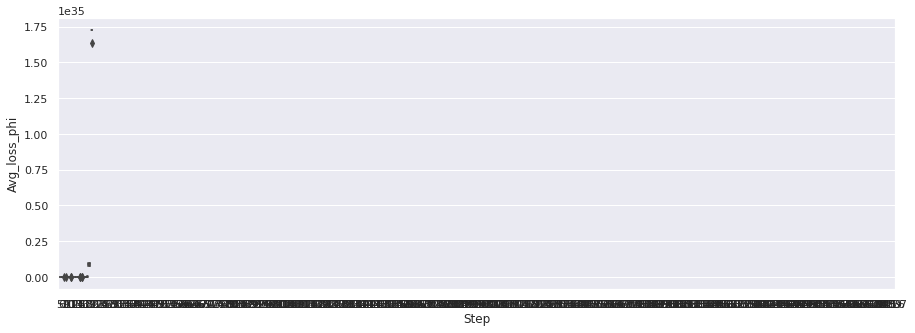

In [115]:
fig, axs = plt.subplots(1, 1,figsize=(15, 5))
sns.boxplot( x=data["Step"], y=data["Avg_loss_phi"] )


resultats avec modif expe

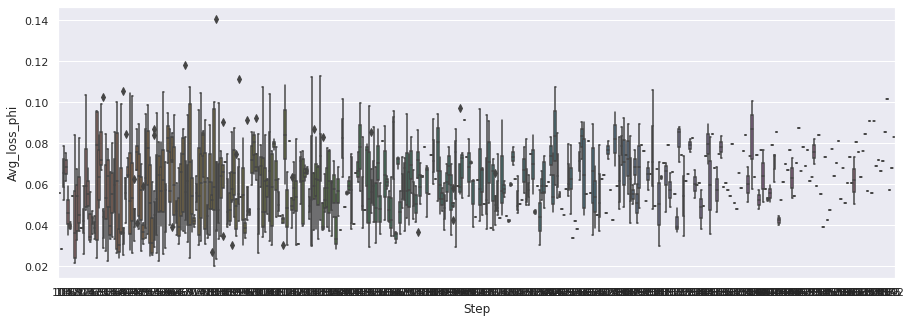

random_state1 (2000, 30)


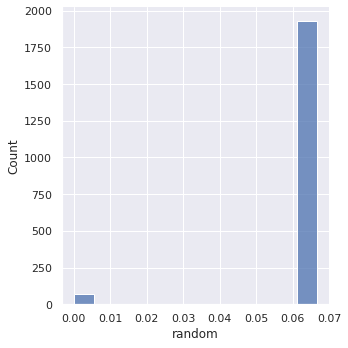

In [116]:


batch = 2000
# dim_state =  env._state_dim
dim_state =  30

random_state1 = np.zeros((batch,dim_state))
random_state2 = np.zeros((batch,dim_state))
avg= np.zeros(batch)


print('random_state1', random_state1.shape)

for k in range(random_state1.shape[0]) : 
    
    ind1 = random.randint(1,dim_state-1)
    random_state1[k, ind1] = 1
    
    ind2 = random.randint(1,dim_state-1)
    random_state2[k, ind2] = 1
    
#     print("norm", np.linalg.norm(random_state1[k] - random_state2[k]))
    
    diff = random_state1[k] - random_state2[k]
    
#     print("square", np.square(diff))
    
#     print("mean",np.mean(np.square(diff), axis=-1))
    
    
#     loss.numpy(), np.mean(np.square(y_true - y_pred), axis=-1))
    
#     print("   ", mean(square(y_true - y_pred), axis=-1)  )
    
    avg[k]=loss_func(random_state1[k], random_state2[k])
    
#     print("random_state1[k]", random_state1[k])
#     print("random_state2[k]", random_state2[k])
    


    
#     print('k',k,ind1, ind2, loss_func(random_state1[k], random_state2[k]))
    
avg
avg_df = pd.DataFrame(avg, columns = ["random"])

# # fig, axs = plt.subplots(2, 3,figsize=(15, 10))

# # sns.displot(

sns.displot(x="random", data=avg_df)
# avg_df
# # sns.lineplot(x="cum_step", y="Reward", data=data, ax = axs[0,1] )
# # sns.lineplot(x="cum_step", y="Avg_loss_r", data=data, ax = axs[0,1] )
# # sns.lineplot(x="cum_step", y="Avg_loss", data=data_see_df, ax = axs[0,2] )
# # sns.lineplot(x="cum_step", y="Eps", data=data_see_df, ax = axs[1,0] )
# plt.show()



# states_double = np.zeros((2,env._state_dim))
# states_double[0,int(env._state_dim*1/3)] = 1
# states_double[1,int(env._state_dim*2/3)] = 1

# actions_double = np.array([0,1])

# states = np.zeros((1,env._state_dim))
# states[0,int(env._state_dim*1/3)]  = 1

# actions = np.array([0])

# states_2 = np.zeros((1,env._state_dim))
# states_2[0,int(env._state_dim*2/3)]  = 1 
# actions_2 = np.array([1])

$$ \boldsymbol{F}_a = \boldsymbol{I} + \gamma  \boldsymbol{M}_a  \overline{\boldsymbol{F}}$$

$$ \dfrac{1}{\gamma} (   \boldsymbol{F}_a  - \boldsymbol{I} )    =  \boldsymbol{M}_a  \overline{\boldsymbol{F}}$$

$$\dfrac{1}{\gamma}  (   \boldsymbol{F}_a  - \boldsymbol{I} )     \overline{\boldsymbol{F}}^{-1}  =  \boldsymbol{M}_a  $$


In [117]:
I = tf.eye(F_bar.shape[0], dtype=tf.dtypes.float32)
gamma = param_agent["gamma"]


In [118]:
M = []
print(" 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right")
for a in range(Fa_reshape.shape[1]) :
    
    MaFbar = 1./gamma * ( Fa_reshape[:,a,:] - I )
    
    Ma = tf.matmul( MaFbar , tf.linalg.inv(F_bar)   )
    
    M.append(Ma)
#     plot_matrice(Fa_reshape[:,a,:]),     plot_matrice(Ma)
M = tf.stack(M, axis=0)
M

 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right


<tf.Tensor: shape=(4, 30, 30), dtype=float32, numpy=
array([[[-1.09801338e+02, -2.55639458e+00,  2.53541827e+00, ...,
          3.27810478e+00, -1.31013942e+00,  7.90572703e-01],
        [-3.86317447e-02,  3.03126603e-01, -5.19019723e-01, ...,
          1.18440509e-01, -3.53851877e-02,  2.20224231e-01],
        [-2.17958298e-02,  1.03422664e-01,  6.04401529e-01, ...,
         -1.34563208e-01,  1.77292377e-01,  1.05320312e-01],
        ...,
        [-3.32749188e-02, -1.61143214e-01, -5.75776510e-02, ...,
          3.93402457e-01, -8.12364519e-02, -1.27039582e-01],
        [ 7.88242519e-02,  1.74828304e-03,  1.67238921e-01, ...,
          2.71837234e-01,  6.15159571e-02,  4.44474369e-01],
        [ 2.81484295e-02, -6.24839105e-02,  2.65386468e-03, ...,
         -1.10501602e-01,  1.81587353e-01, -1.79650694e-01]],

       [[-9.26919556e+01, -2.11282325e+00,  1.79797435e+00, ...,
          2.93187594e+00, -1.46192420e+00,  1.10945547e+00],
        [-4.79366705e-02,  5.43582022e-01, -2.3033

In [119]:
M == agent.M_transi(agent.model_LSFM)

<tf.Tensor: shape=(4, 30, 30), dtype=bool, numpy=
array([[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],

       [[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  Tr

In [120]:
env_name = "SimpleGrid"
env = custom_env(env_name, param_env)

strue =env.reset()
strue   = strue.reshape(1,-1)
phi0 = agent.model_LSFM(strue)["phi"]

a = agent.choose_action_random()[0]
sp1true, rtrue, done, info = env.step(a)

tf.matmul(phi0, M[a]) == agent.next_states_pred(agent.model_LSFM, strue,[a])



<tf.Tensor: shape=(1, 30), dtype=bool, numpy=
array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True]])>

In [121]:

tf.matmul(phi0, M[a]) == agent.next_states_pred(agent.model_LSFM, strue,[a])


<tf.Tensor: shape=(1, 30), dtype=bool, numpy=
array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True]])>

In [122]:
for idl, layer in enumerate(agent.model_LSFM.layers):
    name_a = "ra"
    if layer.name == name_a : 
        wa = layer.weights[0]
#         wa = tf.transpose(wa_transpose)

tf.matmul( phi , wa   )[:, :].shape

TensorShape([36, 4])

In [123]:


# # load LSFM model : 
# agent = Agent(env, param_agent_simu)
# model_load = "LSFM_V2.5_dim1.2-hidden_ratio_12021-05-25_10h-18m-15s"

# agent.model_LSFM = keras.models.load_model(model_load+'/agent_LSFM_model')


# agent.model_LSFM.save( folder_WORK+"/agent_LSFM_model")


In [124]:
# # initialisation data
# data = pd.DataFrame()
        
# # launch experience of simulations
# data, agent_Q = experience(environment, param_agent_simu, agent)

(s,a,r,s') 0 (array([0]), array([5])) 0 0.0 (array([0]), array([5]))
(s,a,r,s') 1 (array([0]), array([5])) 2 0.0 (array([0]), array([4]))
(s,a,r,s') 2 (array([0]), array([4])) 3 0.0 (array([0]), array([5]))
(s,a,r,s') 3 (array([0]), array([5])) 3 0.0 (array([0]), array([5]))
(s,a,r,s') 4 (array([0]), array([5])) 1 0.0 (array([0]), array([11]))
(s,a,r,s') 5 (array([0]), array([11])) 2 0.0 (array([0]), array([10]))
(s,a,r,s') 6 (array([0]), array([10])) 0 0.0 (array([0]), array([4]))
(s,a,r,s') 7 (array([0]), array([4])) 3 0.0 (array([0]), array([5]))
(s,a,r,s') 8 (array([0]), array([5])) 3 0.0 (array([0]), array([5]))
(s,a,r,s') 9 (array([0]), array([5])) 0 0.0 (array([0]), array([5]))
(s,a,r,s') 10 (array([0]), array([5])) 1 0.0 (array([0]), array([11]))
(s,a,r,s') 11 (array([0]), array([11])) 1 0.0 (array([0]), array([17]))
(s,a,r,s') 12 (array([0]), array([17])) 0 0.0 (array([0]), array([11]))
(s,a,r,s') 13 (array([0]), array([11])) 0 0.0 (array([0]), array([5]))
(s,a,r,s') 14 (array

(s,a,r,s') 118 (array([0]), array([35])) 3 0.0 (array([0]), array([35]))
(s,a,r,s') 119 (array([0]), array([35])) 2 0.0 (array([0]), array([34]))
(s,a,r,s') 120 (array([0]), array([34])) 2 0.0 (array([0]), array([33]))
(s,a,r,s') 121 (array([0]), array([33])) 0 0.0 (array([0]), array([27]))
(s,a,r,s') 122 (array([0]), array([27])) 0 -1.0 (array([0]), array([21]))
(s,a,r,s') 123 (array([0]), array([21])) 0 -1.0 (array([0]), array([15]))
(s,a,r,s') 124 (array([0]), array([15])) 1 -1.0 (array([0]), array([21]))
(s,a,r,s') 125 (array([0]), array([21])) 3 0.0 (array([0]), array([22]))
(s,a,r,s') 126 (array([0]), array([22])) 3 0.0 (array([0]), array([23]))
(s,a,r,s') 127 (array([0]), array([23])) 3 0.0 (array([0]), array([23]))
(s,a,r,s') 128 (array([0]), array([23])) 3 0.0 (array([0]), array([23]))
(s,a,r,s') 129 (array([0]), array([23])) 1 0.0 (array([0]), array([29]))
(s,a,r,s') 130 (array([0]), array([29])) 2 0.0 (array([0]), array([28]))
(s,a,r,s') 131 (array([0]), array([28])) 3 0.0 (

<AxesSubplot:>

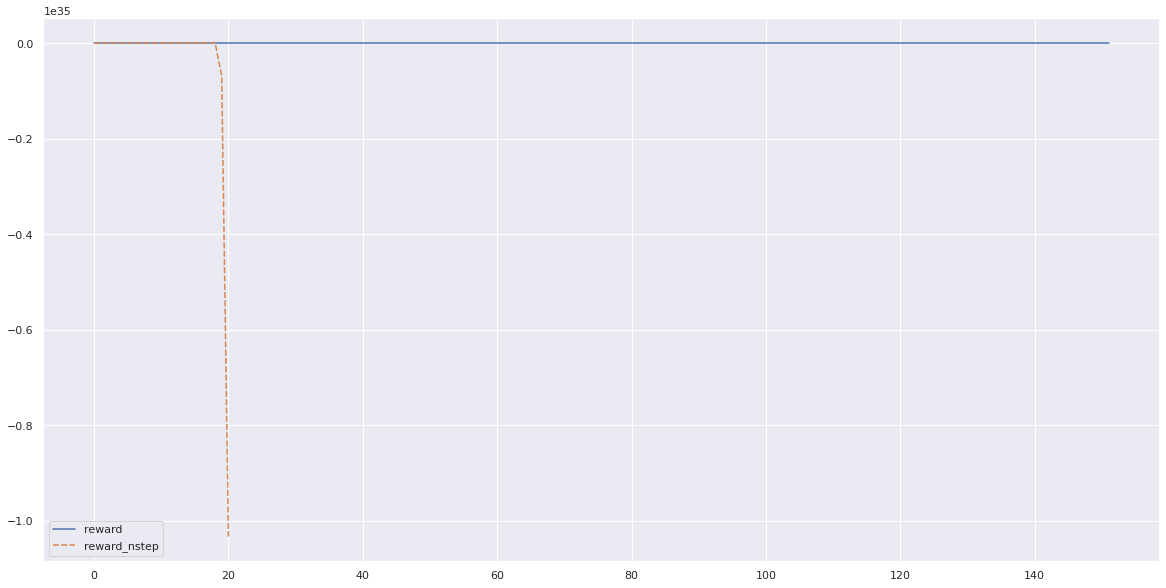

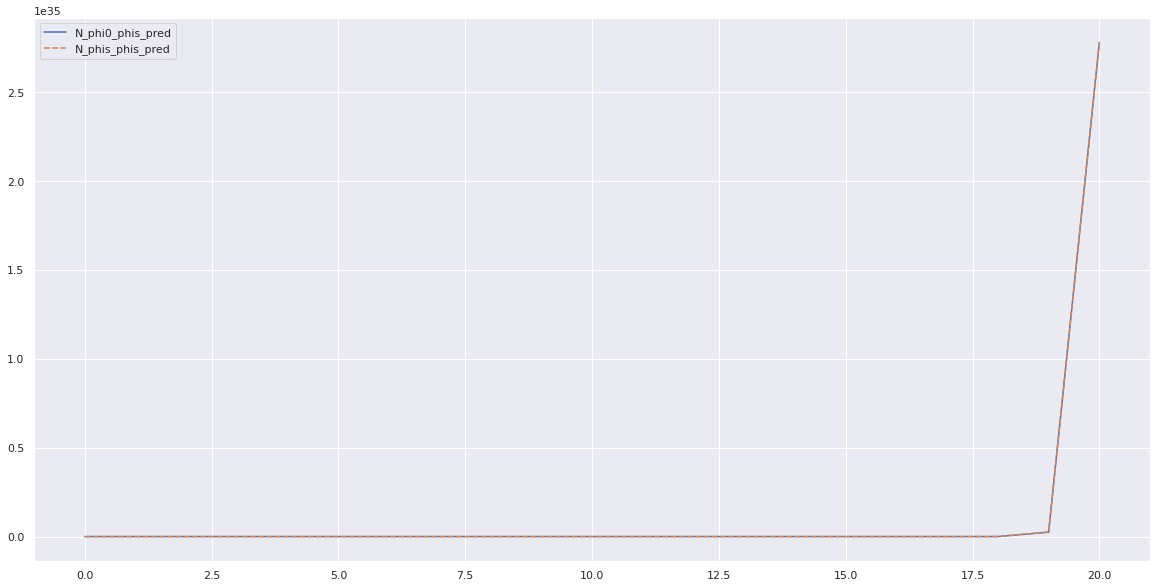

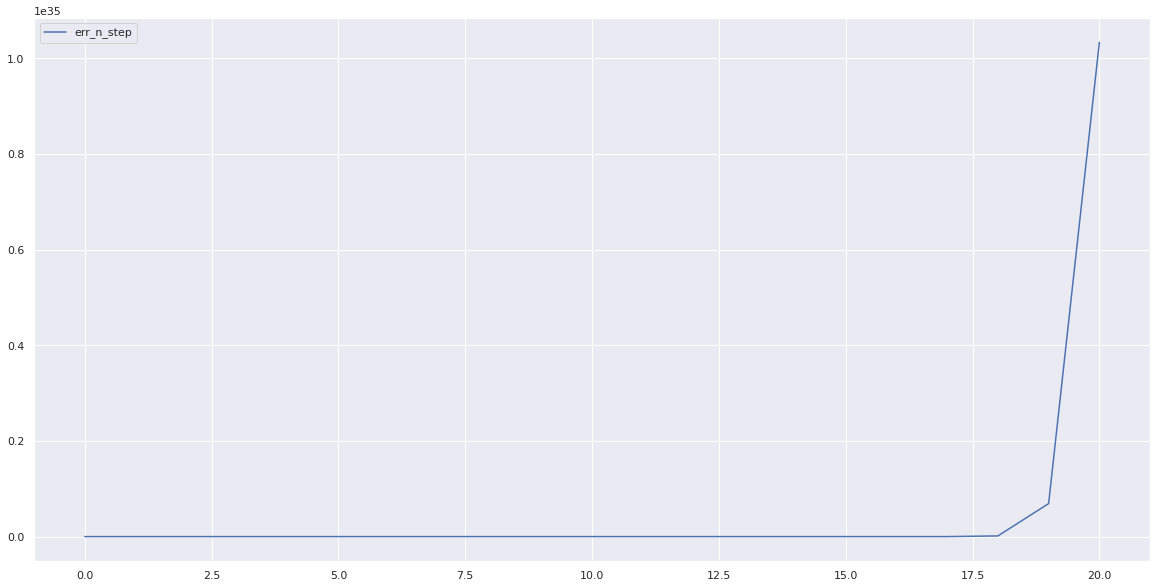

In [125]:
def reset_model() : 
    
    strue =env.reset()
    strue   = strue.reshape(1,-1)
    phi0 = agent.model_LSFM(strue)["phi"]
    phis_pred = phi0

    N_reward   = []
    action = []
    reward = []
    reward_pred = []
    reward_pred_M = []
    steps = []
    N_phitrue = []
    N_phi0_phis_pred = []

    N_phis_phis_pred = []

def loss_func(ypred, ytrue) : 
#     MSE
#     return keras.losses.mean_squared_error(ypred, ytrue)
#     MAE
    return keras.losses.mean_absolute_error(ypred, ytrue)


param_env = {
    "agent_pos":[0, 5], 
    "goal_pos":[[5,0] ],
    "reward_minmax":[-1.,0.],
    "reward_user_defined":True,
    "reward_pos":[[0, 0],[0, 1],[0, 2],[0, 3],[0, 4],[0, 5], 
                  [1, 0],[1, 1],[1, 2],[1, 3],[1, 4],[1, 5], 
                                              [2, 4],[2, 5], 
                                              [3, 4],[3, 5], 
                  [4, 0],[4, 1],[4, 2],[4, 3],[4, 4],[4, 5], 
                  [5, 0],[5, 1],[5, 2],[5, 3],[5, 4],[5, 5]],
    "grid_size" : 6,
    "pattern": "empty",
    "obs_mode":"index",
}




env_name = "SimpleGrid"
env = custom_env(env_name, param_env)

strue =env.reset()
strue   = strue.reshape(1,-1)
phi0 = agent.model_LSFM(strue)["phi"]
phis_pred = phi0

N_reward   = []
action = []
reward = []
reward_pred = []
reward_pred_M = []
steps = []
N_phitrue = []
N_phi0_phis_pred = []

N_phis_phis_pred = []




# 0 - Up  /  1 - Down  /  2 - Left  / 3 - Right
actions = [3,3,3,3,3,1,
           2,2,2,2,2,1,
           3,3,3,3,3,1,
           2,2,2,2,2,1,
           3,3,3,3,3,1,
           2,2,2,2,2]

    
    
for step in range(500) : 
#     env.render()
    steps.append(step)

    a = agent.choose_action_random()[0]
#     a = actions[step]

    sp1true, rtrue, done, info = env.step(a)


#         print("step, a", step, a, done)


    strue   = strue.reshape(1,-1)

    #  phistrue = Phi(strue)
    phistrue = agent.model_LSFM(strue)["phi"]
    psistrue = agent.model_LSFM(strue)["Fa"]

    N_phitrue.append(tf.norm(phistrue, axis=1).numpy()[0])
#     print(tf.norm(phistrue, axis=1))

    phisp1_pred = tf.matmul( phis_pred,M[a])

    
    
    
    
#     print('phisp1_pred', loss_func(phisp1_pred,agent.next_states_pred(agent.model_LSFM, strue,[a])).numpy()[0] )

#     print('phi', loss_func(phisp1_pred,agent.next_phi_pred(agent.model_LSFM, phis_pred,[a])).numpy()[0] )

    
    
    
    N_phi0_phis_pred.append(loss_func(phi0,phis_pred).numpy()[0])

    N_phis_phis_pred.append(loss_func(phistrue,phis_pred).numpy()[0])

#     rpred =  agent.model_LSFM(s)["ra"]
#     rpred = agent.get_from_actions( s, [a], agent.model_LSFM, "ra")

    rpred = tf.matmul( phistrue , wa   )[:, a]
    rpred_M = tf.matmul( phis_pred , wa   )[:, a]

    reward_pred_M.append(rpred_M.numpy()[0])


    sp1true = sp1true.reshape(1,-1)
    phisp1true = agent.model_LSFM(sp1true)["phi"]
    psisp1true = agent.model_LSFM(sp1true)["Fa"]

    N_reward.append(np.abs(rpred.numpy()[0] **2 - rtrue**2)**0.5)


    action.append(a)
    reward.append(rtrue)
    reward_pred.append(rpred.numpy()[0])

#     plot_matrice(phistrue)
    print("(s,a,r,s')",step, np.nonzero(strue),a,rtrue,np.nonzero(sp1true) )



    strue=sp1true

    phis_pred = phisp1_pred

#     print("(s,a,r,s')",a )

    if done : 
        break


    
        

N_reward_df = pd.DataFrame(
    np.transpose([N_reward, action, reward, reward_pred, steps, N_phitrue, N_phi0_phis_pred, reward_pred_M, N_phis_phis_pred] ) , 
                           columns=[ "N_reward", "action" , "reward" , 
                                    "reward_1step", "steps", "N_phitrue" , "N_phi0_phis_pred", "reward_nstep", "N_phis_phis_pred"])

N_reward_df["err_n_step"] = abs(N_reward_df["reward"]**2 - N_reward_df["reward_nstep"]**2)**0.5
N_reward_df

N_reward_df
fig, axs = plt.subplots(1, 1,figsize=(20, 10))
sns.lineplot( data=N_reward_df.loc[:,["reward", "reward_nstep"]])

plt.savefig(folder_WORK+"/"+dt_string+"reward_1_n_step.jpg")

fig, axs = plt.subplots(1, 1,figsize=(20, 10))
sns.lineplot( data=N_reward_df.loc[:,[ "N_phi0_phis_pred", "N_phis_phis_pred"]])
plt.savefig(folder_WORK+"/"+dt_string+"phi_n_step.jpg")


fig, axs = plt.subplots(1, 1,figsize=(20, 10))
sns.lineplot( data=N_reward_df.loc[:,[ "err_n_step"]])
# plt.savefig(folder_WORK+"/"+dt_string+"phi_n_step.jpg")

# sns.lineplot(x="steps" , y="reward_pred", data=N_reward_df, legend=True)
# sns.lineplot(x="steps" , y="reward", data=N_reward_df)


# sns.boxplot( x=N_reward_df["steps"], y=N_reward_df["N_reward"], 
#            saturation=0.7, width=0.5, dodge=True, fliersize=1, linewidth=1., whis=0)
# sns.scatterplot(data=data_Q_episode_par_10, x="Episode", y=col, hue=hue)
# axs.set(yscale="log")



In [126]:

# plot_matrice(phi0)
# plot_matrice(phi1)
# plot_matrice(P_phi0_a)



# plot_matrice(N_phi0_phi1)
# plot_matrice(N_phi0_Pphi0)
# plot_matrice(N_phi1_Pphi0)


In [127]:
state_init = np.zeros((1,env._state_dim))
state_init[0,0]  = 1
state_init

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

In [128]:
agent.model_LSFM(states)["phi"]

<tf.Tensor: shape=(36, 30), dtype=float32, numpy=
array([[0.        , 0.01115854, 0.        , ..., 0.        , 0.25467843,
        0.        ],
       [0.        , 0.        , 0.05280417, ..., 0.        , 0.25675988,
        0.        ],
       [0.        , 0.15247715, 0.25978833, ..., 0.        , 0.1097166 ,
        0.        ],
       ...,
       [0.        , 0.        , 0.25818667, ..., 0.05503556, 0.17194839,
        0.48316246],
       [0.        , 0.40198267, 0.        , ..., 0.        , 0.        ,
        0.11551885],
       [0.        , 0.5023314 , 0.        , ..., 0.06310683, 0.        ,
        0.05286317]], dtype=float32)>

## Eigen decomposition

In [129]:
eigen_values_A, eigen_vectors_A = tf.linalg.eigh(F_bar)
eigen_values_A, eigen_vectors_A

(<tf.Tensor: shape=(30,), dtype=float32, numpy=
 array([-0.6419739, -0.5332286,  0.010675 ,  0.1692811,  0.2166113,
         0.5165256,  0.5813222,  0.6356259,  0.6775014,  0.9189786,
         0.9568036,  1.0838194,  1.1280811,  1.2669668,  1.3359015,
         1.3888737,  1.5133029,  1.8042824,  1.8784623,  1.9881935,
         2.0390677,  2.4353774,  2.600602 ,  3.0457945,  3.2741802,
         3.6685257,  4.3742123,  5.945447 ,  6.441947 ,  9.5620365],
       dtype=float32)>,
 <tf.Tensor: shape=(30, 30), dtype=float32, numpy=
 array([[-4.10292960e-05, -2.13701715e-04, -9.99997556e-01,
          1.06509740e-03, -1.61105930e-03, -1.37356619e-04,
          7.66803802e-04,  5.46075695e-04,  2.31432787e-05,
          3.98714154e-04,  4.85276716e-04,  4.76547022e-04,
          4.21727280e-04,  3.90452828e-04,  3.89504974e-04,
          6.62745078e-05, -6.73792892e-05, -1.95591070e-04,
          1.69760642e-05,  8.43174007e-07,  1.63639324e-05,
          1.86557285e-04,  1.19506847e-04,  1.14

In [130]:
new_diag_lambda = tf.linalg.diag(eigen_values_A)
new_diag_lambda

<tf.Tensor: shape=(30, 30), dtype=float32, numpy=
array([[-0.6419739,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ],
       [ 0.       , -0.5332286,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.       ],
       [ 0.       ,  0.       ,  0.010675 ,  0.       ,  0.       ,
         0.       ,  0.       ,  0.       ,  0.       ,  0.     